In [1]:
# load packages
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import pickle

import geopandas as gpd # http://geopandas.org/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py
import contextily as ctx

import shapely.wkt # https://stackoverflow.com/questions/51855917/shapely-polygon-from-string
from shapely.geometry import Point, LineString, MultiLineString, Polygon
from shapely.ops import cascaded_union

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + "/capstone_nyc"

# from google.colab import files # along with 'files.download('xxx.csv')' 

# import os
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# for dirname, _, filenames in os.walk('/content/gdrive'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
def Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_bike', injured_killed='injured'):
    pp = df_col.groupby(list(set([c for c in ['year',col,hue] if pd.notnull(c)]))).sum().reset_index(drop=False)
    pp = pp.loc[(pp['year'] >= 2013) & (pp['year'] <= 2018)] # only year = [2013,2014,2015,2016,2017,2018]

    if pd.notnull(col) & pd.notnull(hue):
        sns.lmplot(x='year', y="number of persons "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of motorist "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of pedestrians "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html
        sns.lmplot(x='year', y="number of cyclist "+injured_killed, col=col, hue=hue, data=pp, col_wrap=10, aspect=0.5) # https://seaborn.pydata.org/tutorial/regression.html

    else:
        pp = pd.melt(pp, 
             id_vars=['year'], 
             value_vars=['number of persons '+injured_killed,'number of motorist '+injured_killed,'number of pedestrians '+injured_killed,'number of cyclist '+injured_killed],
             var_name='type', 
             value_name='number of '+injured_killed)
        sns.lmplot(x='year', y="number of "+injured_killed, hue='type', data=pp, aspect=1.2) # https://seaborn.pydata.org/tutorial/regression.html

    plt.show()

def Plot_Geoms_On_NYCMap(geoms, ON_MAP=True):
    #ref) https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
    # df = gpd.GeoDataFrame(geometry=df_col['location'].dropna().loc[1:1000], crs={'init':'epsg:4326'}) 
    df = gpd.GeoDataFrame(geometry=geoms, crs={'init':'epsg:4326'}) 
    df = df.to_crs(epsg=3857) # convert data to the same CRS to combine our polygons and background tiles in the same map

    # NYC borough boundaries
    #ref) http://geopandas.org/gallery/plotting_basemap_background.html#sphx-glr-gallery-plotting-basemap-background-py
    df_nyc = gpd.read_file(gpd.datasets.get_path('nybb')) # NYC borough boundary data that is available in geopandas datasets
    df_nyc = df_nyc.to_crs(epsg=3857) # convert data to the same CRS to combine our polygons and background tiles in the same map

    #--- plot --------------------
    fig, ax = plt.subplots(figsize=(15,15))
    df_nyc.plot(ax=ax, color='none', edgecolor='b', alpha=1.0, linewidth=1.5) # NYC borough boundaries
    df.plot(ax=ax, color='r', edgecolor='r', alpha=0.2, markersize=1)
    if ON_MAP:
#         ctx.add_basemap(ax)
#         ctx.add_basemap(ax, zoom=12)
        ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    
# Plot_Geoms_On_NYCMap(df_col.loc[df_col['on street name'].isnull(),'location'].dropna())    

#-------------------------------------------------------------------------------
# from nltk.metrics.distance import edit_distance
# # http://maf.directory/zp4/abbrev.html
# word = 'lane'
# ww = pd.DataFrame({'word':aa, 'count':0}).groupby('word').count().reset_index().sort_values(by='count', ascending=False)
# ww['ii'] = ww['word'].apply(lambda w: word[0] != w[0])
# ww['ss'] = ww['word'].apply(lambda w: edit_distance(word, w, transpositions = True))
# ww.sort_values(by=['ii','ss'])
def find_road_type(streetname):
    if len(set(streetname.lower().split()).intersection(['expressway','expressay','expresswaay','expresway','exressway','express','expway','expwy','expre','exway','expy','exwy','exwpy','exp','exp.'])) > 0:
        return 'expressway'
    elif len(set(streetname.lower().split()).intersection(['parkway','parrkway','parlway','parkwway','parkwayy','parkwary','prkwy','pkwy'])) > 0:
        return 'parkway'
#     elif len(set(streetname.lower().split()).intersection(['highway','hwy'])) > 0:
#         return 'highway'
    elif len(set(streetname.lower().split()).intersection(['drive','dr'])) > 0:
        return 'drive'
#     elif ((len(set(streetname.lower().split()).intersection(['drive','dr'])) > 0) &
#           (len(set(streetname.lower().split()).intersection(['fdr'])) == 0)):
#         return 'drive'
#     elif len(set(streetname.lower().split()).intersection(['fdr'])) > 0:
#         return 'fdr drive'
#     elif len(set(streetname.lower().split()).intersection(['broadway'])) > 0:
#         return 'broadway'
#     elif len(set(streetname.lower().split()).intersection(['turnpike','tpke'])) > 0:
#         return 'turnpike'
#     elif len(set(streetname.lower().split()).intersection(['thruway','thruwy','thurway','throughway'])) > 0:
#         return 'thruway'
#     elif len(set(streetname.lower().split()).intersection(['concourse','concours'])) > 0:
#         return 'concourse'
    elif len(set(streetname.lower().split()).intersection(['bridge','bridge/','bridge,','bridgte','brdg','brg'])) > 0:
        return 'bridge'
    
    elif len(set(streetname.lower().split()).intersection(['street','st','st.'])) > 0:
        return 'street'
#     elif len(set(streetname.lower().split()).intersection(['boulevard','blvd'])) > 0:
#         return 'boulevard'
    elif len(set(streetname.lower().split()).intersection(['avenue','ave'])) > 0:
        return 'avenue'
    elif len(set(streetname.lower().split()).intersection(['road','rd'])) > 0:
        return 'road'
    else:
        return 'others'

In [3]:
# load dataset
df_col = pd.read_csv('NYPD_Motor_Vehicle_Collisions_-_Crashes.zip', dtype={'ZIP CODE':str})
df_col.rename(columns={c:c.lower() for c in df_col.columns}, inplace=True) # make column names lower-case

# convert data type
# df_col['zip code'] = df_col['zip code'].apply(lambda x: str(x).replace('.0','') if not pd.isnull(x) else np.nan)
df_col['location'] = df_col['location'].apply(lambda x: shapely.wkt.loads(x) if not pd.isnull(x) else np.nan)

# correct wrong data
df_col.loc[
    ((40.489 > df_col['latitude']) | (df_col['latitude'] > 40.924) |  # NYC boundary
     (-74.272 > df_col['longitude']) | (df_col['longitude'] > -73.689)) # NYC boundary
    , ['latitude','longitude','location']    
] = np.nan

print(df_col.shape)
print(df_col.info())
df_col.head()

(1558237, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558237 entries, 0 to 1558236
Data columns (total 29 columns):
date                             1558237 non-null object
time                             1558237 non-null object
borough                          1088134 non-null object
zip code                         1087947 non-null object
latitude                         1364727 non-null float64
longitude                        1364727 non-null float64
location                         1364727 non-null object
on street name                   1254948 non-null object
cross street name                1044964 non-null object
off street name                  211127 non-null object
number of persons injured        1558220 non-null float64
number of persons killed         1558206 non-null float64
number of pedestrians injured    1558237 non-null int64
number of pedestrians killed     1558237 non-null int64
number of cyclist injured        1558237 non-null int64
number of cyclist 

date   time borough zip code   latitude  longitude  \
0  08/24/2019  11:53     NaN      NaN        NaN        NaN   
1  08/24/2019  13:22     NaN      NaN        NaN        NaN   
2  08/24/2019  23:00     NaN      NaN        NaN        NaN   
3  08/24/2019  23:50     NaN      NaN        NaN        NaN   
4  08/23/2019   0:12     NaN      NaN  40.825134  -73.95141   

                      location                    on street name  \
0                          NaN  CROSS BRONX EXPY RAMP              
1                          NaN  VERRAZANO BRIDGE LOWER             
2                          NaN  MEEKER AVENUE                      
3                          NaN  MERIDIAN RD                        
4  POINT (-73.95141 40.825134)  BROADWAY                           

  cross street name off street name  number of persons injured  \
0               NaN             NaN                        3.0   
1               NaN             NaN                        0.0   
2               NaN             NaN                        0.0   
3      NEW YORK AVE             NaN                        0.0   
4               NaN             NaN                        0.0   

   number of persons killed  number of pedestrians injured  \
0                       0.0                              0   
1                       0.0                              0   
2                       0.0                              0   
3                       0.0                              0   
4                       0.0                              0   

   number of pedestrians killed  number of cyclist injured  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   number of cyclist killed  number of motorist injured  \
0                         0                           3   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   number of motorist killed   contributing factor vehicle 1  \
0                          0                 Other Vehicular   
1                          0  Reaction to Uninvolved Vehicle   
2                          0             Passing Too Closely   
3                          0         View Obstructed/Limited   
4                          0            Unsafe Lane Changing   

  contributing factor vehicle 2 contributing factor vehicle 3  \
0  Aggressive Driving/Road Rage                           NaN   
1                   Unspecified                           NaN   
2                   Unspecified                           NaN   
3                           NaN                           NaN   
4                   Unspecified                           NaN   

  contributing factor vehicle 4 contributing factor vehicle 5  unique id  \
0                           NaN                           NaN    4194003   
1                           NaN                           NaN    4194562   
2                           NaN                           NaN    4194211   
3                           NaN                           NaN    4193896   
4                           NaN                           NaN    4193507   

                   vehicle type code 1 vehicle type code 2  \
0                                Sedan               Sedan   
1  Station Wagon/Sport Utility Vehicle               Sedan   
2                                Sedan          Motorcycle   
3  Station Wagon/Sport Utility Vehicle                 NaN   
4                        Pick-up Truck               Sedan   

  vehicle type code 3 vehicle type code 4 vehicle type code 5  
0                 NaN                 NaN            

In [4]:
# impute data : borough, zip code, on street name
def Load_New_Data_From_OpenStreetMap():
    zz = []
    for n in range(0,35):
        print(n)
        zz.append(pd.read_pickle('openstreetmap/geopy_(%s).pickle'%n))
    zz = pd.concat(zz, axis=0).reset_index(drop=True)
    print(zz.shape)
    zz['zip code'] = zz['zip code'].apply(lambda x: str(x).replace('.0','') if not pd.isnull(x) else np.nan)
    zz = zz.drop_duplicates(subset='unique id')
    print(zz.shape)
    print(zz.info())
    zz.head()
    
    aa = zz['geopy'].apply(lambda x: x['address']['county'].upper()).map({
        'NEW YORK COUNTY':'MANHATTAN', 
        'BRONX COUNTY':'BRONX', 
        'QUEENS COUNTY':'QUEENS', 
        'KINGS COUNTY':'BROOKLYN',
        'RICHMOND COUNTY':'STATEN ISLAND'})
    bb = zz['geopy'].apply(lambda x: x['address']['postcode'][0:5].replace('1122O','11220')
                           if 'postcode' in x['address'].keys() else np.nan).apply(lambda y: y if (y not in ['(718)','NY 11','NY 10']) & (not pd.isnull(y)) else np.nan)
    cc = zz['geopy'].apply(lambda x: x['address']['road'].upper()
                           if 'road' in x['address'].keys() else np.nan)

    zz.loc[zz['borough'].isnull(),'borough'] = aa[zz['borough'].isnull()]
    zz.loc[zz['zip code'].isnull(),'zip code'] = bb[zz['zip code'].isnull()]
    zz.loc[zz['on street name'].isnull(),'on street name'] = cc[zz['on street name'].isnull()]

    print(zz.info())
    zz.head()   
    return zz

zz = Load_New_Data_From_OpenStreetMap()
df_col.set_index('unique id', inplace=True)
df_col.loc[zz['unique id'],['borough','zip code','on street name']] = zz[['unique id','borough','zip code','on street name']].set_index('unique id')
df_col.reset_index(inplace=True)

print(df_col.shape)
print(df_col.info())
df_col.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
(482606, 7)
(482606, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482606 entries, 0 to 482605
Data columns (total 7 columns):
unique id         482606 non-null int64
latitude          482606 non-null float64
longitude         482606 non-null float64
borough           177468 non-null object
zip code          177298 non-null object
on street name    231399 non-null object
geopy             482606 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 29.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 482606 entries, 0 to 482605
Data columns (total 7 columns):
unique id         482606 non-null int64
latitude          482606 non-null float64
longitude         482606 non-null float64
borough           482288 non-null object
zip code          481442 non-null object
on street name    479847 non-null object
geopy             482606 non-null object
dtypes: float64(2

unique id        date   time    borough zip code   latitude  longitude  \
0    4194003  08/24/2019  11:53        NaN      NaN        NaN        NaN   
1    4194562  08/24/2019  13:22        NaN      NaN        NaN        NaN   
2    4194211  08/24/2019  23:00        NaN      NaN        NaN        NaN   
3    4193896  08/24/2019  23:50        NaN      NaN        NaN        NaN   
4    4193507  08/23/2019   0:12  MANHATTAN    10031  40.825134  -73.95141   

                      location                    on street name  \
0                          NaN  CROSS BRONX EXPY RAMP              
1                          NaN  VERRAZANO BRIDGE LOWER             
2                          NaN  MEEKER AVENUE                      
3                          NaN  MERIDIAN RD                        
4  POINT (-73.95141 40.825134)  BROADWAY                           

  cross street name off street name  number of persons injured  \
0               NaN             NaN                        3.0   
1               NaN             NaN                        0.0   
2               NaN             NaN                        0.0   
3      NEW YORK AVE             NaN                        0.0   
4               NaN             NaN                        0.0   

   number of persons killed  number of pedestrians injured  \
0                       0.0                              0   
1                       0.0                              0   
2                       0.0                              0   
3                       0.0                              0   
4                       0.0                              0   

   number of pedestrians killed  number of cyclist injured  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          0   

   number of cyclist killed  number of motorist injured  \
0                         0                           3   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   number of motorist killed   contributing factor vehicle 1  \
0                          0                 Other Vehicular   
1                          0  Reaction to Uninvolved Vehicle   
2                          0             Passing Too Closely   
3                          0         View Obstructed/Limited   
4                          0            Unsafe Lane Changing   

  contributing factor vehicle 2 contributing factor vehicle 3  \
0  Aggressive Driving/Road Rage                           NaN   
1                   Unspecified                           NaN   
2                   Unspecified                           NaN   
3                           NaN                           NaN   
4                   Unspecified                           NaN   

  contributing factor vehicle 4 contributing factor vehicle 5  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

                   vehicle type code 1 vehicle type code 2  \
0                                Sedan               Sedan   
1  Station Wagon/Sport Utility Vehicle               Sedan   
2                                Sedan          Motorcycle   
3  Station Wagon/Sport Utility Vehicle                 NaN   
4                        Pick-up Truck               Sedan   

  vehicle type code 3 vehicle type code 4 vehicle type code 5  
0                 NaN        

In [5]:
#--- create new features ------------------------------------------------------------
df_col['date_time'] = pd.to_datetime(df_col['date'] + ' ' + df_col['time'], format='%m/%d/%Y %H:%M')
df_col['year'] = df_col['date_time'].dt.year
df_col['month'] = df_col['date_time'].dt.month
df_col['dayofweek'] = df_col['date_time'].dt.dayofweek
df_col['hour'] = df_col['date_time'].dt.hour

df_col['is_borough_null'] = df_col['borough'].isnull()
df_col['borough'].fillna('N/A', inplace=True)

df_col['is_location_null'] = df_col['location'].isnull()

df_col['road_type'] = df_col['on street name'].apply(lambda x: find_road_type(x) if not pd.isnull(x) else 'N/A')

df_col['is_expressway'] = df_col['road_type'].apply(lambda x: x in ['bridge','drive','expressway','parkway'])

df_col['number of persons injured/killed'] = df_col['number of persons injured'] + df_col['number of persons killed']
df_col['number of motorist injured/killed'] = df_col['number of motorist injured'] + df_col['number of motorist killed']
df_col['number of pedestrians injured/killed'] = df_col['number of pedestrians injured'] + df_col['number of pedestrians killed']
df_col['number of cyclist injured/killed'] = df_col['number of cyclist injured'] + df_col['number of cyclist killed']

In [ ]:
Plot_Injuries_vs_Year(df_col, col=None, hue=None, injured_killed='injured')

In [ ]:
Plot_Injuries_vs_Year(df_col, col=None, hue=None, injured_killed='killed')

In [ ]:
Plot_Injuries_vs_Year(df_col, col='borough', hue='borough', injured_killed='injured')

In [ ]:
Plot_Injuries_vs_Year(df_col, col='borough', hue='borough', injured_killed='killed')

In [ ]:
Plot_Injuries_vs_Year(df_col, col='road_type', hue='road_type')

In [ ]:
Plot_Injuries_vs_Year(df_col, col='is_expressway', hue='is_expressway')

In [ ]:
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='expressway','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='parkway','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='bridge','location'].dropna(), ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type']=='drive','location'].dropna(), ON_MAP=False)

Plot_Geoms_On_NYCMap(df_col.loc[df_col['road_type'].apply(lambda x: x in ['expressway','parkway','bridge','drive']),'location'].dropna())

In [29]:
df_arterial = pd.read_csv("dot_VZV_Arterial_Slow_Zones_20190903.csv")
df_bike = pd.read_csv("dot_VZV_Bike_Priority_Districts_20190903.csv")
df_cross = pd.read_csv("dot_VZV_Enhanced_Crossings_20190903.csv")
df_left = pd.read_csv("dot_VZV_Left_Turn_Traffic_Calming_20190903.csv")
df_slow = pd.read_csv("dot_VZV_Neighborhood_Slow_Zones_20190903.csv")
df_signal = pd.read_csv("dot_VZV_Signal_Timing_20190903.csv")
df_spdhump = pd.read_csv("dot_VZV_Speed_Humps_20190903.csv")
df_spdlimit = pd.read_csv("dot_VZV_Speed_Limits_20190903.csv")

df_arterial['the_geom'] = df_arterial['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_bike['the_geom'] = df_bike['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_cross['the_geom'] = df_cross['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_left['the_geom'] = df_left['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_slow['the_geom'] = df_slow['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_signal['the_geom'] = df_signal['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_spdhump['the_geom'] = df_spdhump['the_geom'].apply(lambda x: shapely.wkt.loads(x))
df_spdlimit['the_geom'] = df_spdlimit['the_geom'].apply(lambda x: shapely.wkt.loads(x))

if False: 
    is_arterial, geoms_arterial = Is_Event_of_Geom(df_col, df_arterial, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_arterial, geoms_arterial], open('is_arterial.pickle', 'wb'))
    # 10000 : 37 s
    # total : 1h 22min 9s
else:
    is_arterial, geoms_arterial = pickle.load(open('is_arterial.pickle', 'rb'))        

if False: 
    is_bike, geoms_bike = Is_Event_of_Geom(df_col, df_bike, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_bike, geoms_bike], open('is_bike.pickle', 'wb'))
    # 10000 : 11.6 s
    # 100000 : 
else:
    is_bike, geoms_bike = pickle.load(open('is_bike.pickle', 'rb'))    

if False: 
    is_cross, geoms_cross = Is_Event_of_Geom(df_col, df_cross, num_head = 100000000, THRESHOLD_DISTANCE = 0.0002)
    pickle.dump([is_cross, geoms_cross], open('is_cross.pickle', 'wb'))
    # 10000 : 1.61 s
    # 100000 : 13.7 s
    # total : 3min 45s
else:
    is_cross, geoms_cross = pickle.load(open('is_cross.pickle', 'rb'))

if False: 
    is_left, geoms_left = Is_Event_of_Geom(df_col, df_left, num_head = 100000000, THRESHOLD_DISTANCE = 0.0002)
    pickle.dump([is_left, geoms_left], open('is_left.pickle', 'wb'))
    # 10000 : 2.63 s
    # 100000 :
    # total : 5min 37s
else:
    is_left, geoms_left = pickle.load(open('is_left.pickle', 'rb'))    

if False: 
    is_slow, geoms_slow = Is_Event_of_Geom(df_col, df_slow, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_slow, geoms_slow], open('is_slow.pickle', 'wb'))
    # 10000 : 14.2 s
    # total : 25min 41s
else:
    is_slow, geoms_slow = pickle.load(open('is_slow.pickle', 'rb'))        

if False: 
    is_signal, geoms_signal = Is_Event_of_Geom(df_col, df_signal, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_signal, geoms_signal], open('is_signal.pickle', 'wb'))
    # 10000 : 22.1 s
    # 100000 : 41min 28s
else:
    is_signal, geoms_signal = pickle.load(open('is_signal.pickle', 'rb'))            

if False: 
    is_spdhump, geoms_spdhump = Is_Event_of_Geom(df_col, df_spdhump, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
    pickle.dump([is_spdhump, geoms_spdhump], open('is_spdhump.pickle', 'wb'))
    # 10000 : 14.6 s
    # total: 39min 43s
else:
    is_spdhump, geoms_spdhump = pickle.load(open('is_spdhump.pickle', 'rb'))                    
    
# if True: 
#     is_spdlimit, geoms_spdlimit = Is_Event_of_Geom(df_col, df_spdlimit, num_head = 100000000, THRESHOLD_DISTANCE = 0.0001)
#     pickle.dump([is_spdlimit, geoms_spdlimit], open('is_spdlimit.pickle', 'wb'))
#     # 100 : 7min 45s
#     # 1000 : 9min 46s
# else:
#     is_spdlimit, geoms_spdlimit = pickle.load(open('is_spdlimit.pickle', 'rb'))                    

df_col['is_arterial'] = is_arterial
df_col['is_bike'] = is_bike
df_col['is_cross'] = is_cross
df_col['is_left'] = is_left
df_col['is_slow'] = is_slow
df_col['is_signal'] = is_signal
df_col['is_spdhump'] = is_spdhump
# df_col['is_spdlimit'] = is_spdlimit

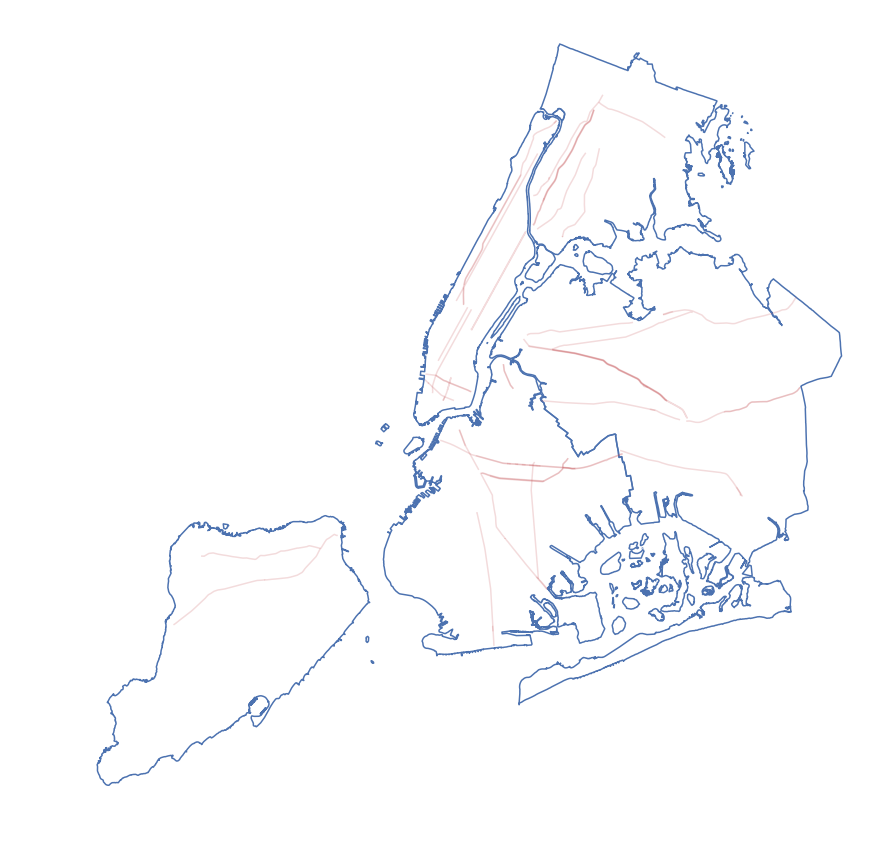

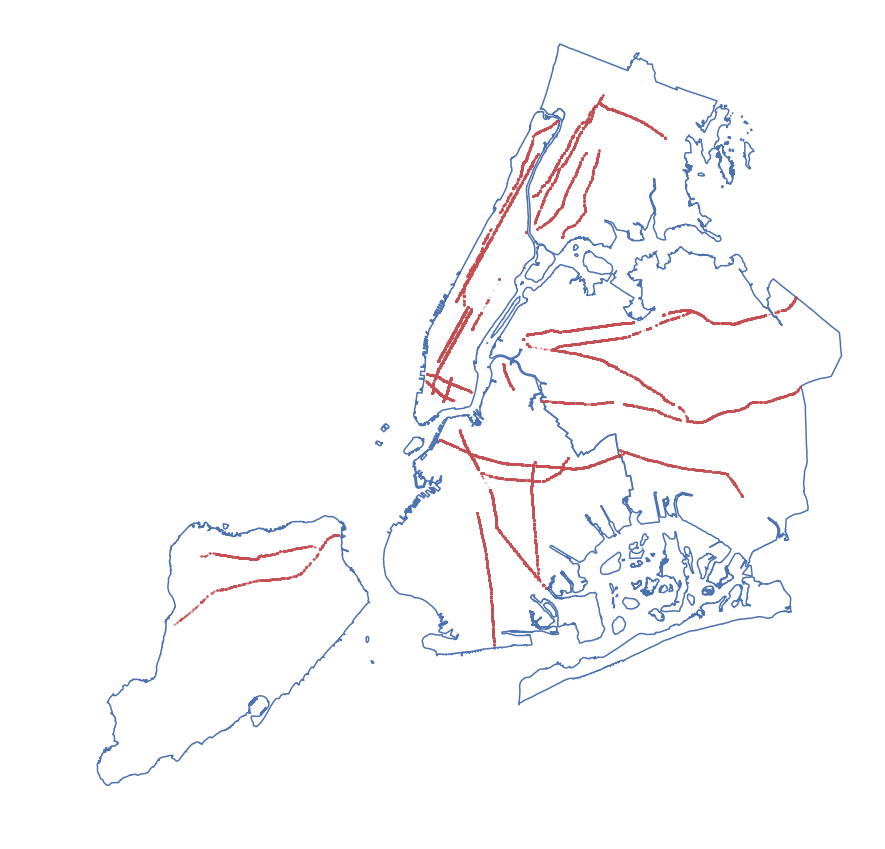

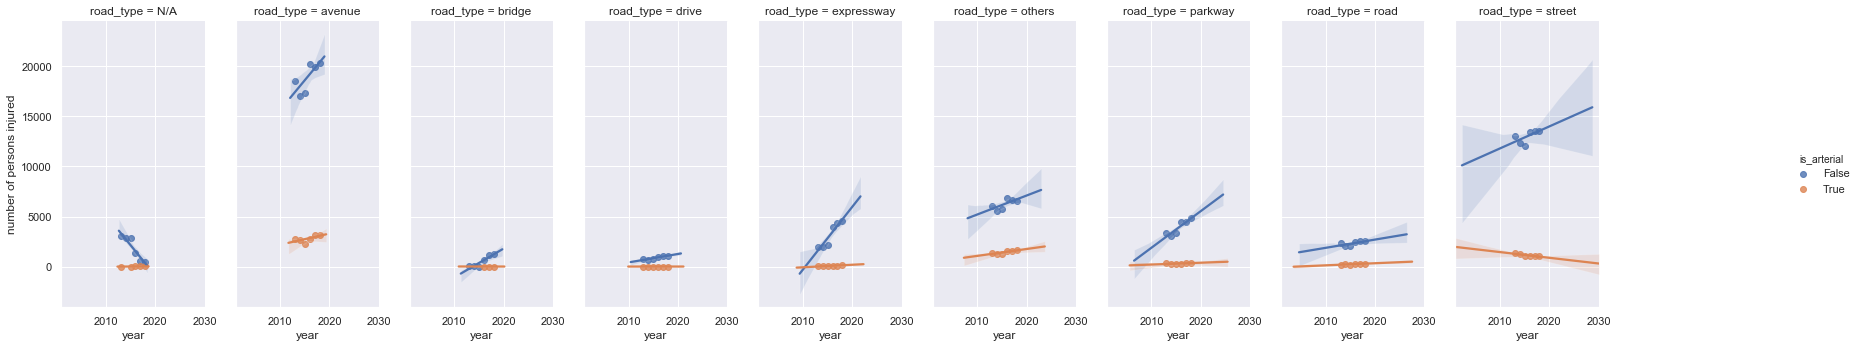

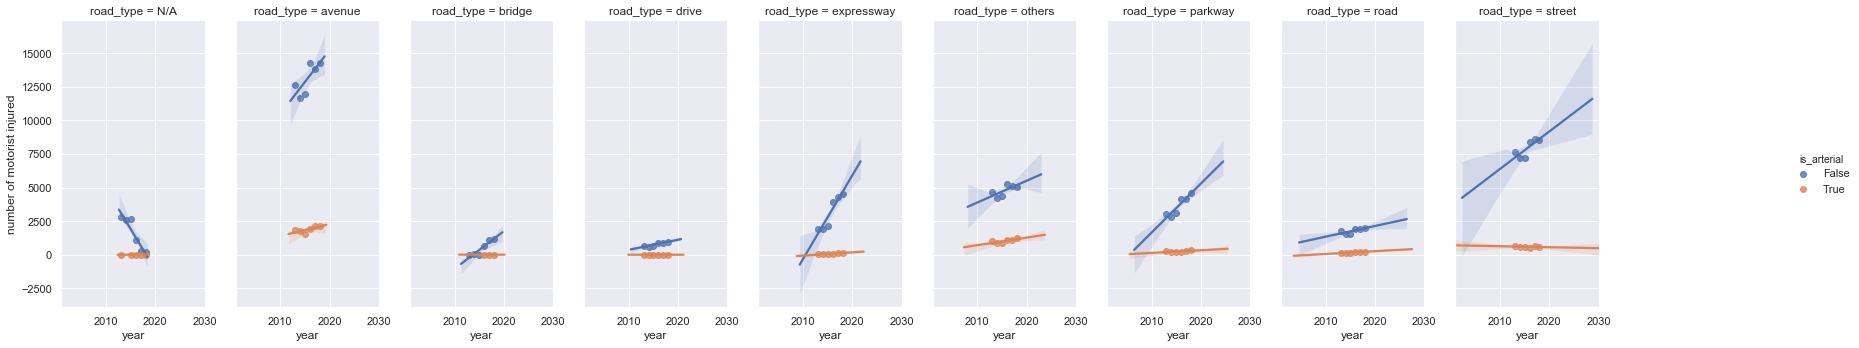

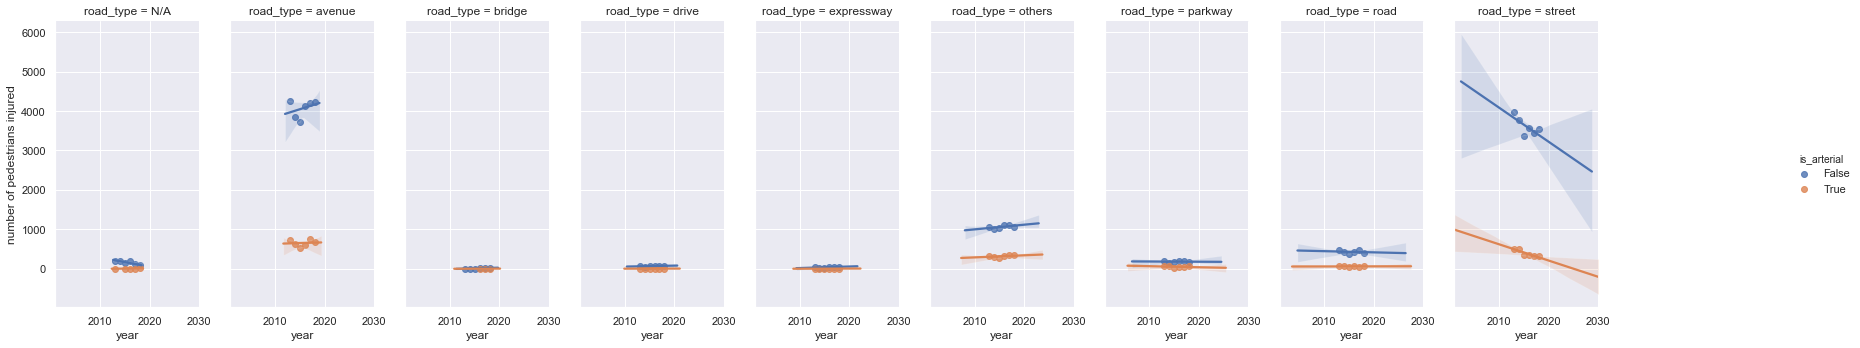

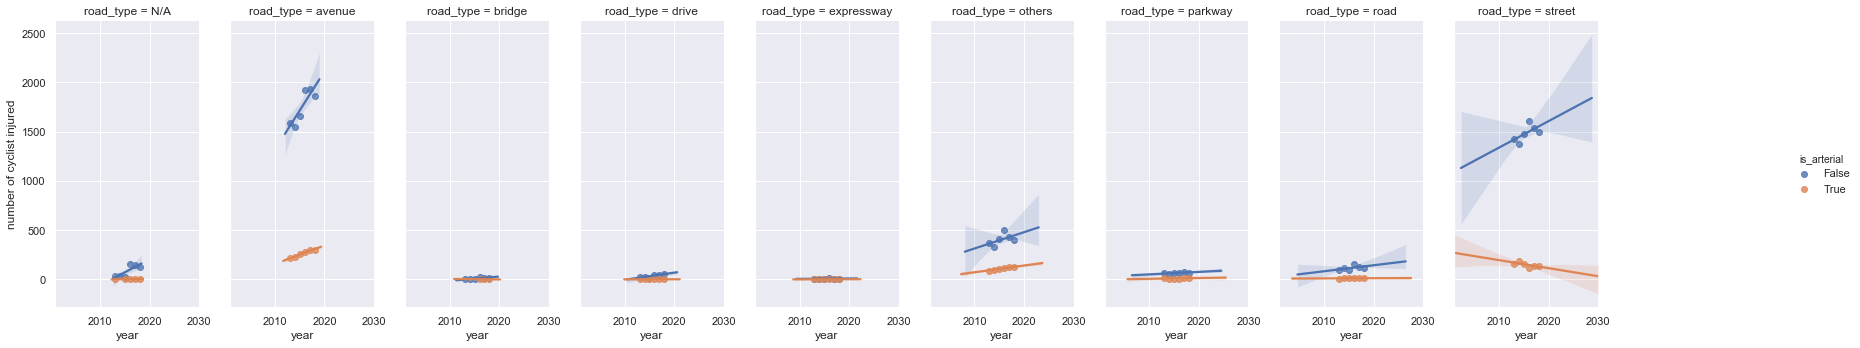

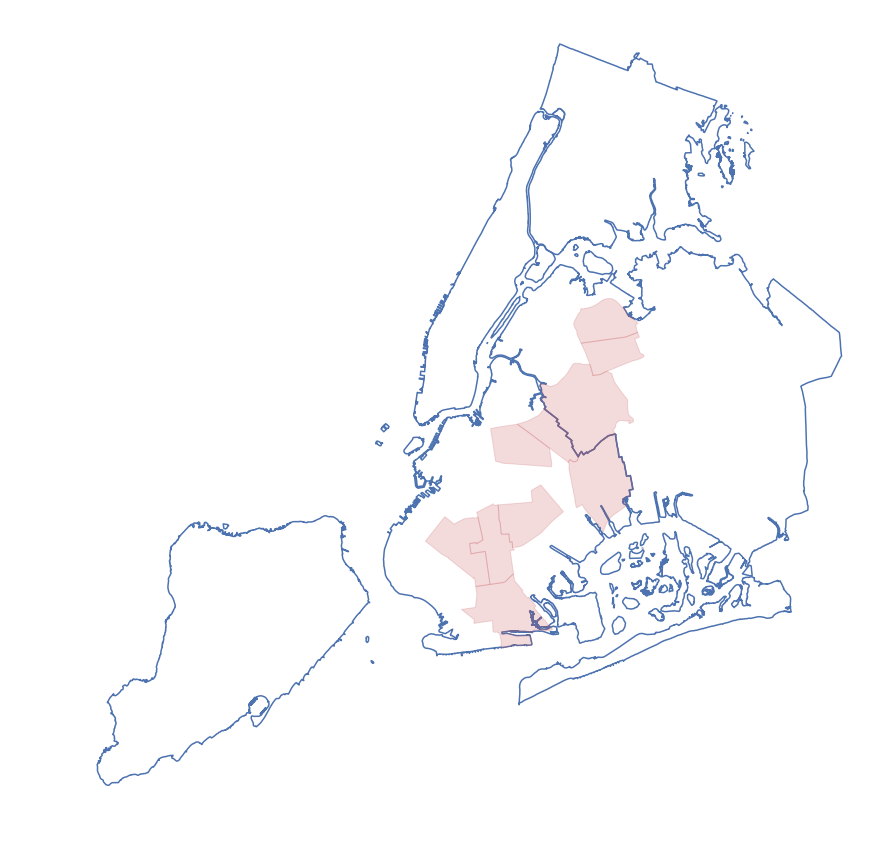

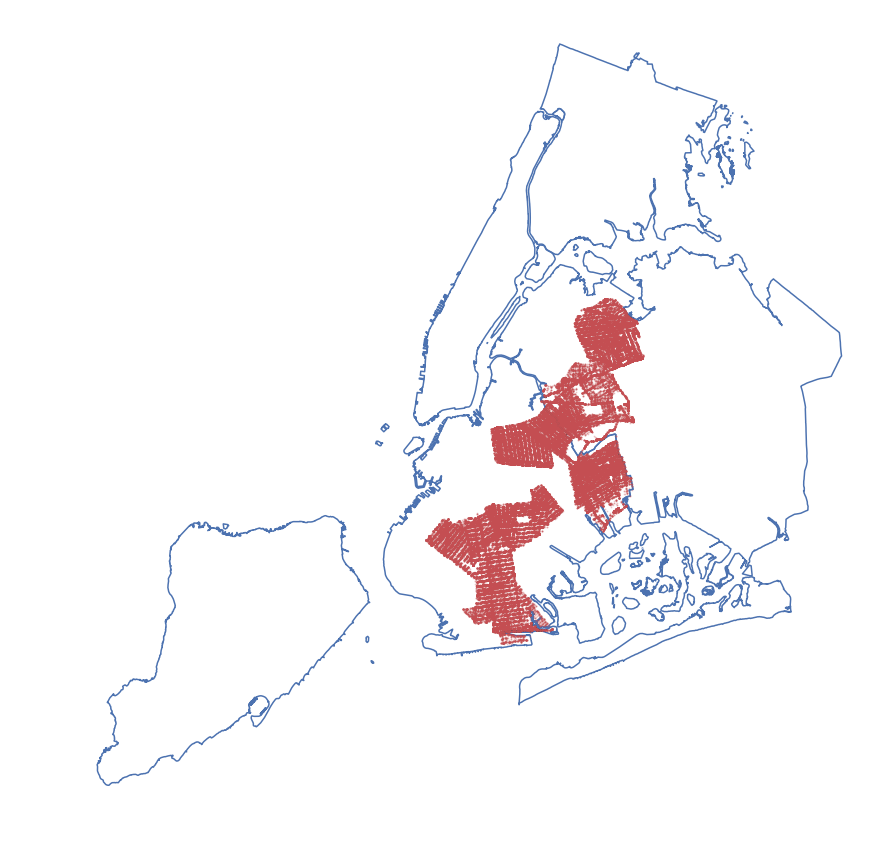

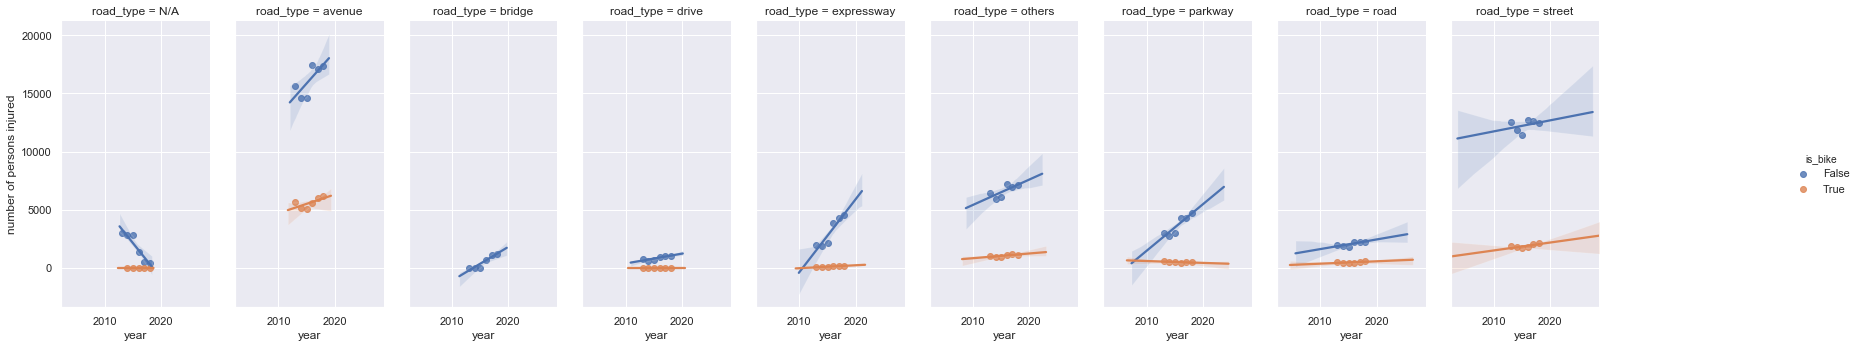

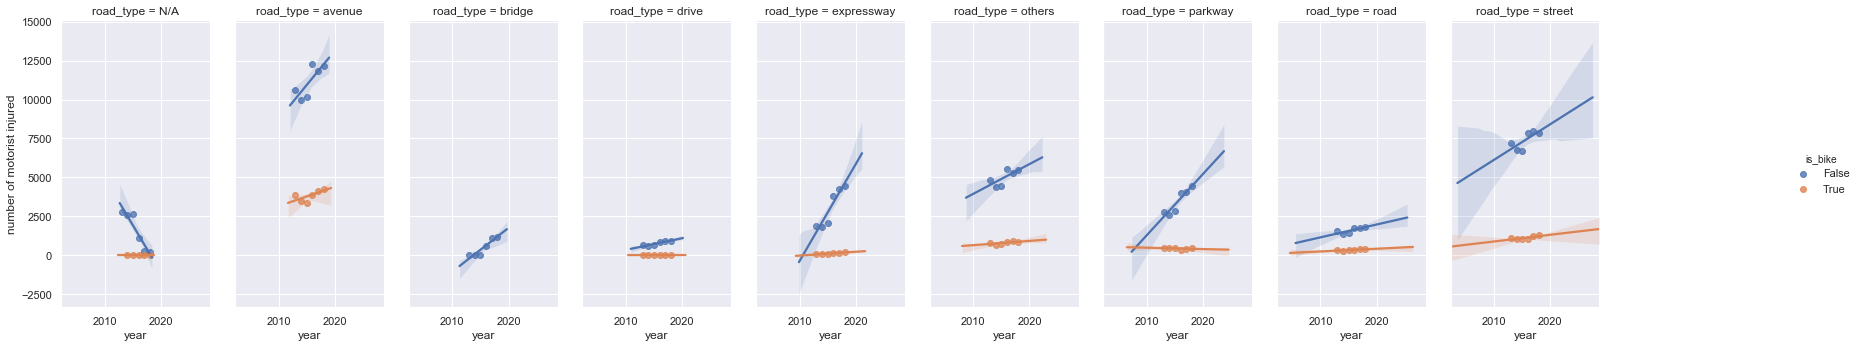

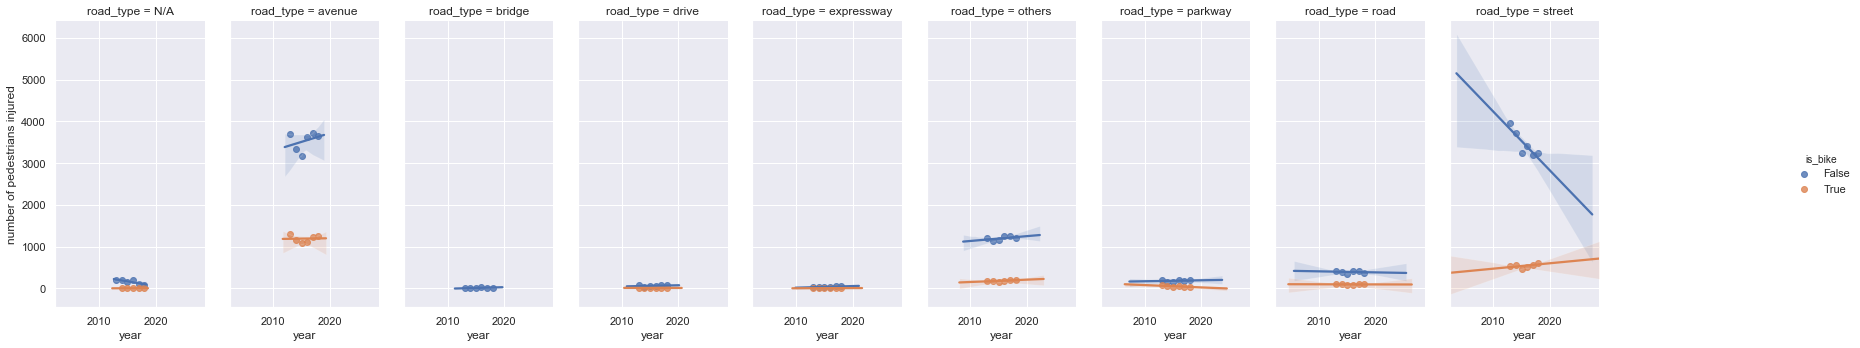

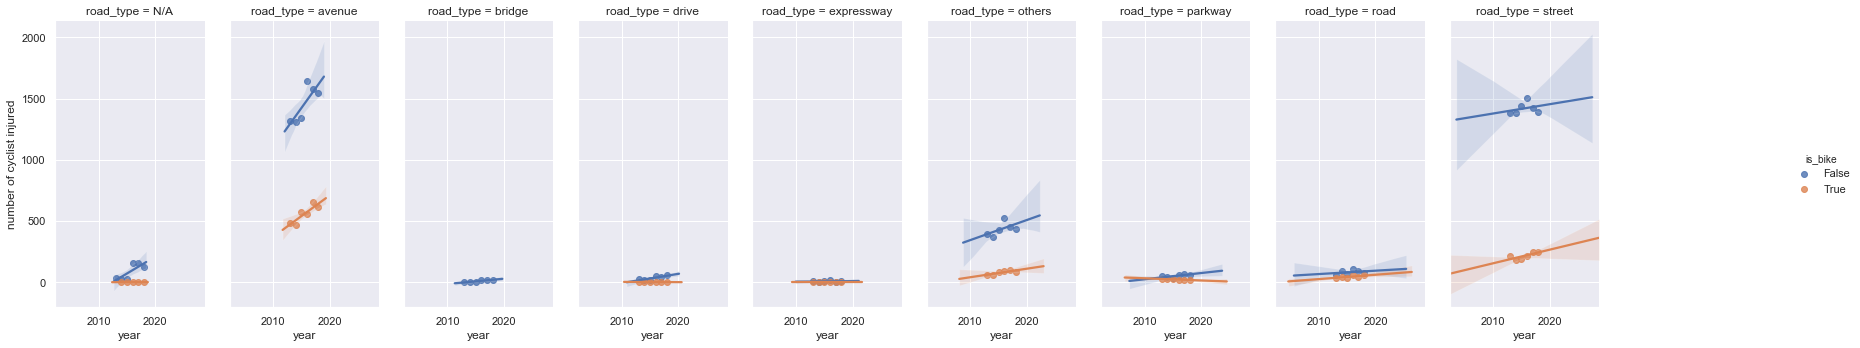

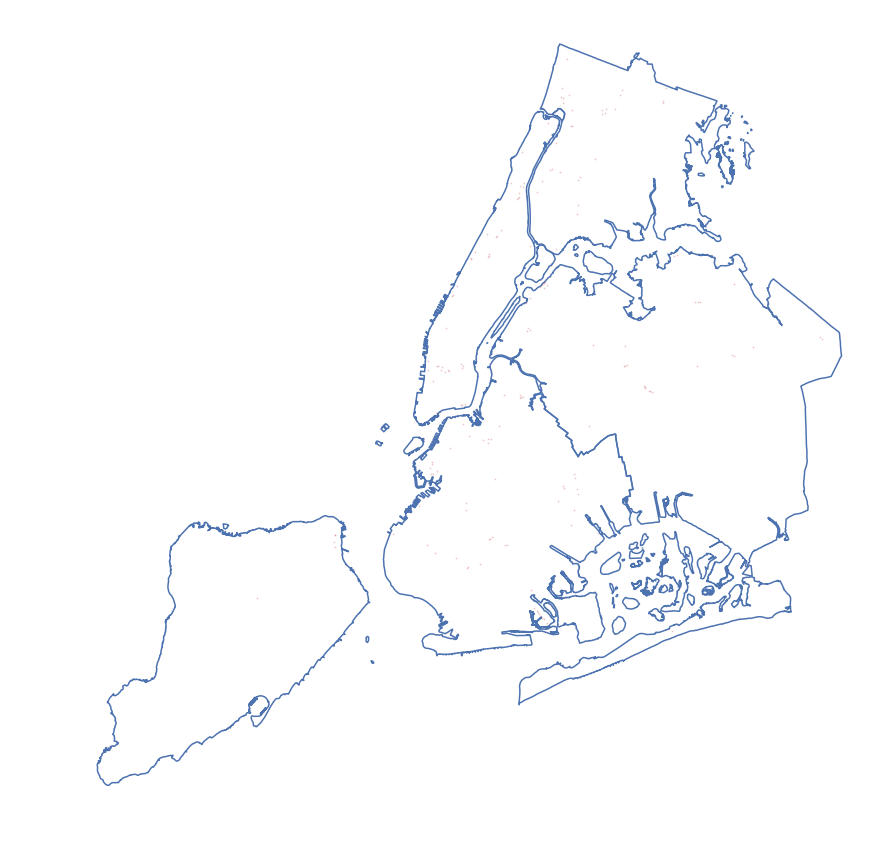

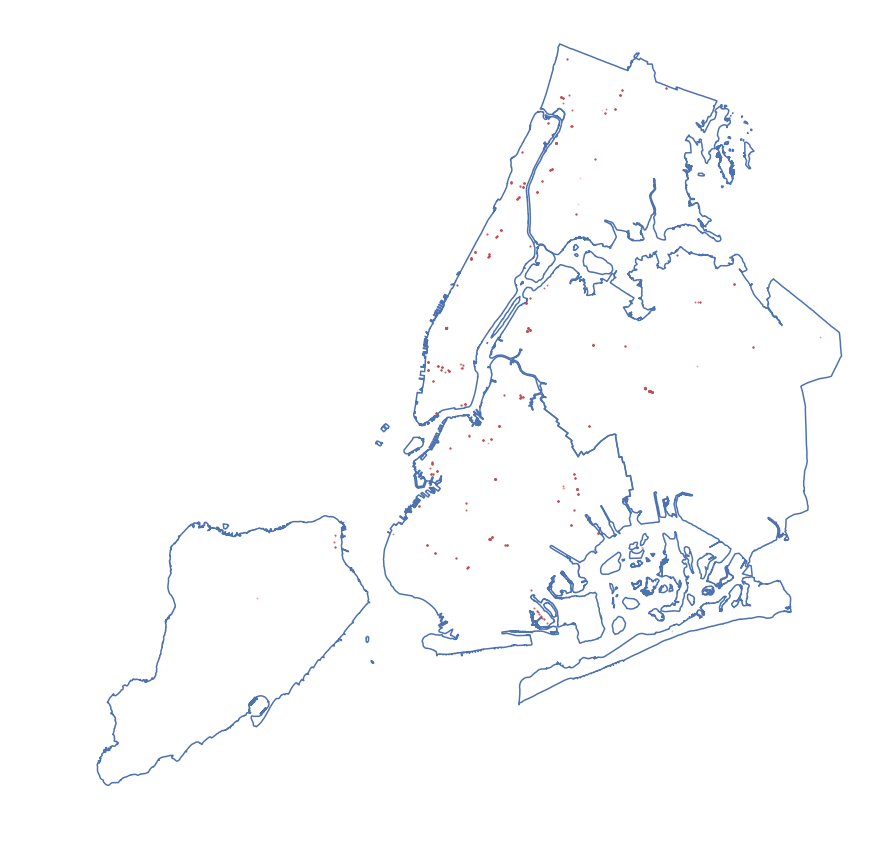

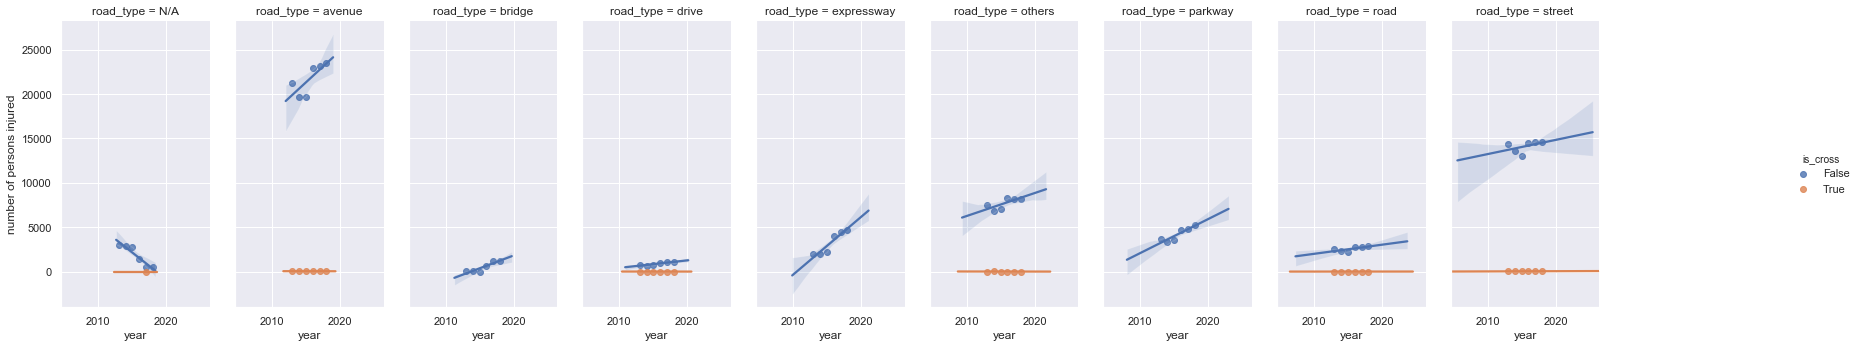

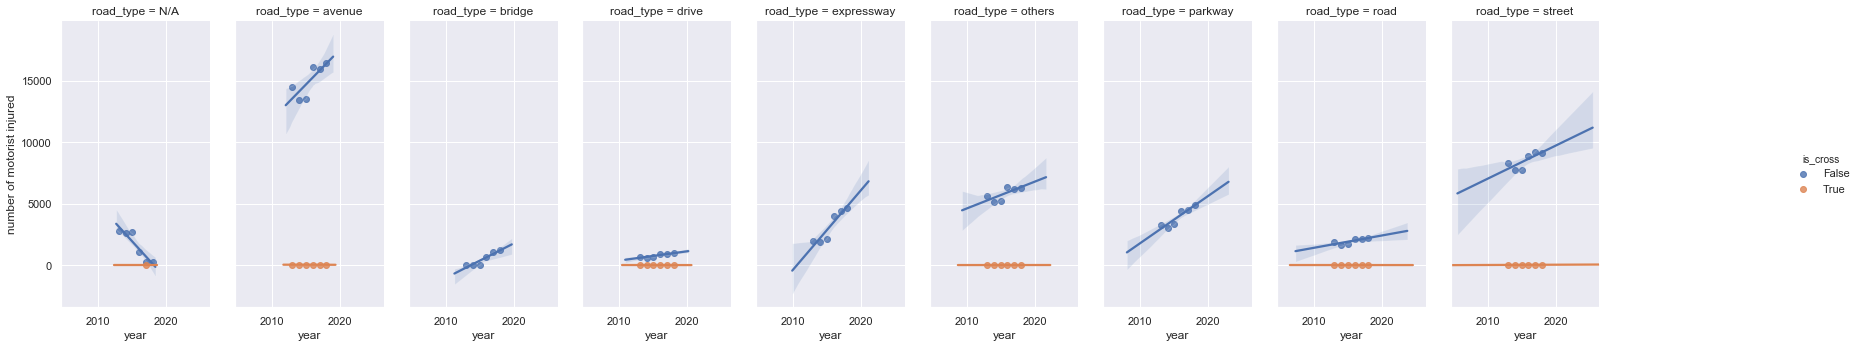

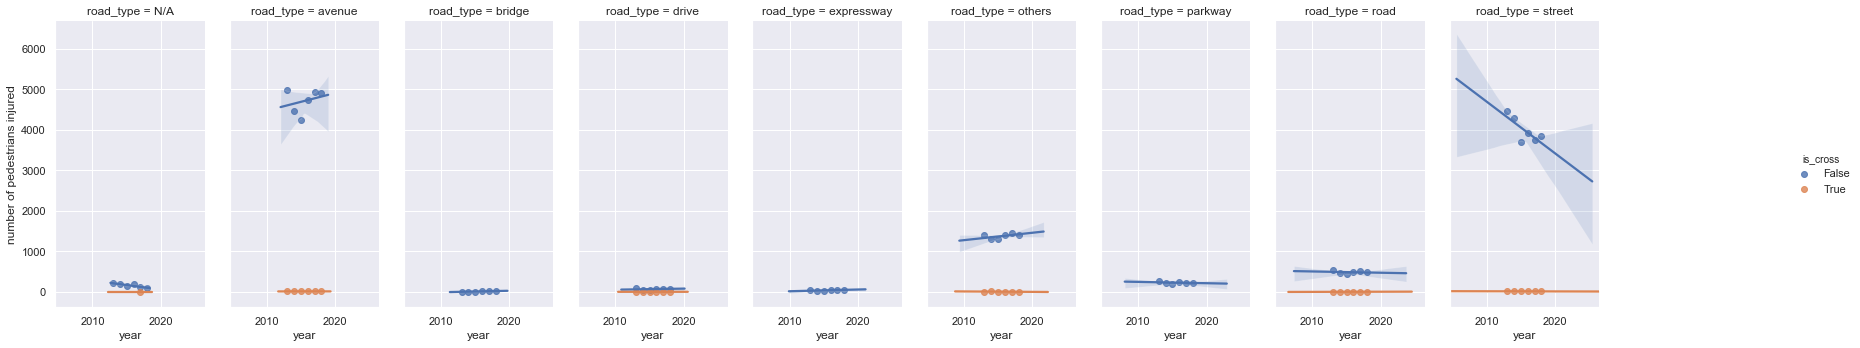

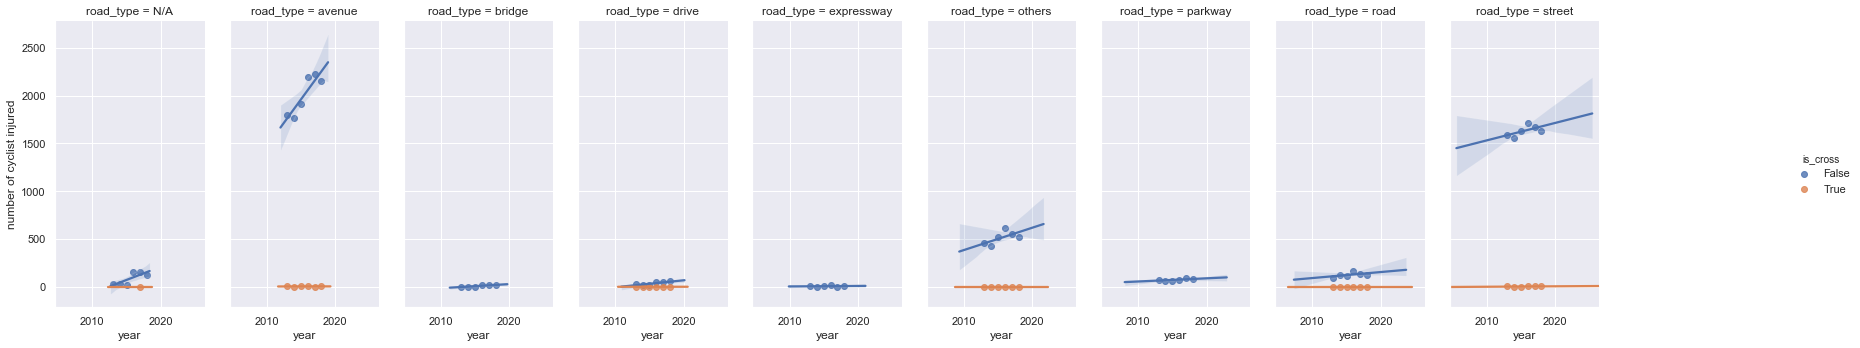

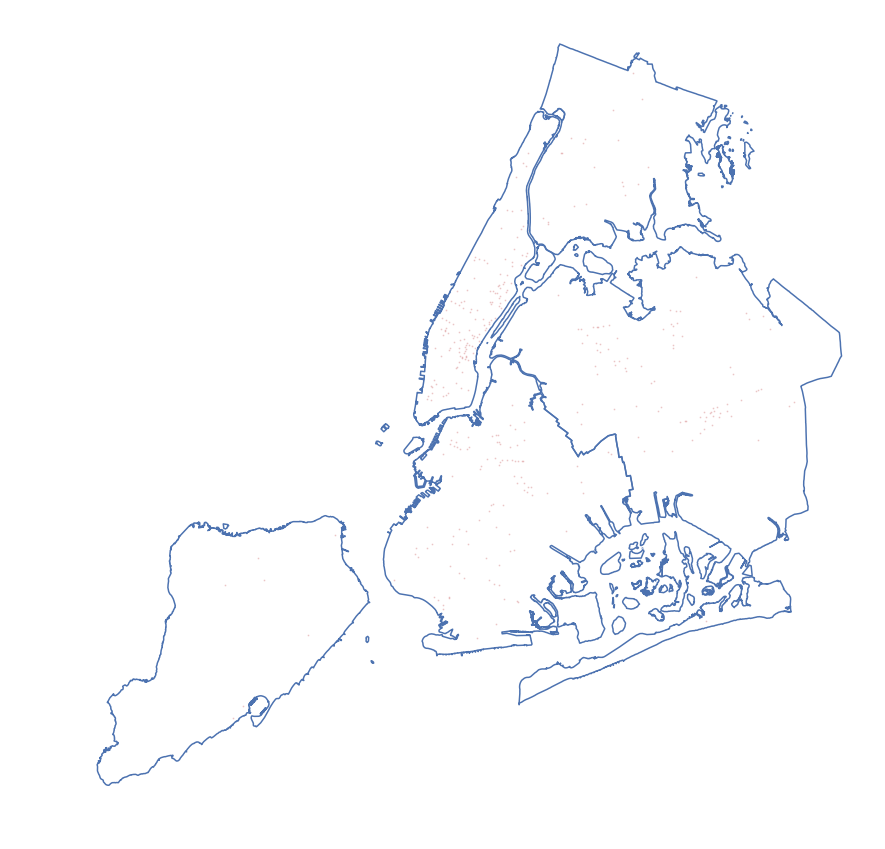

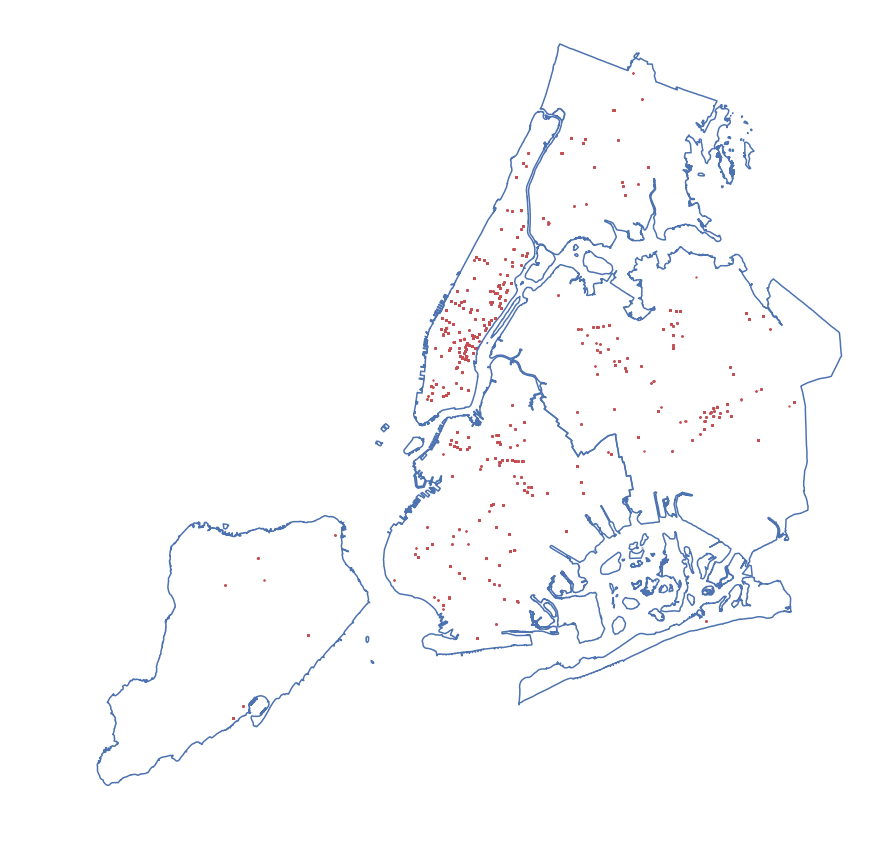

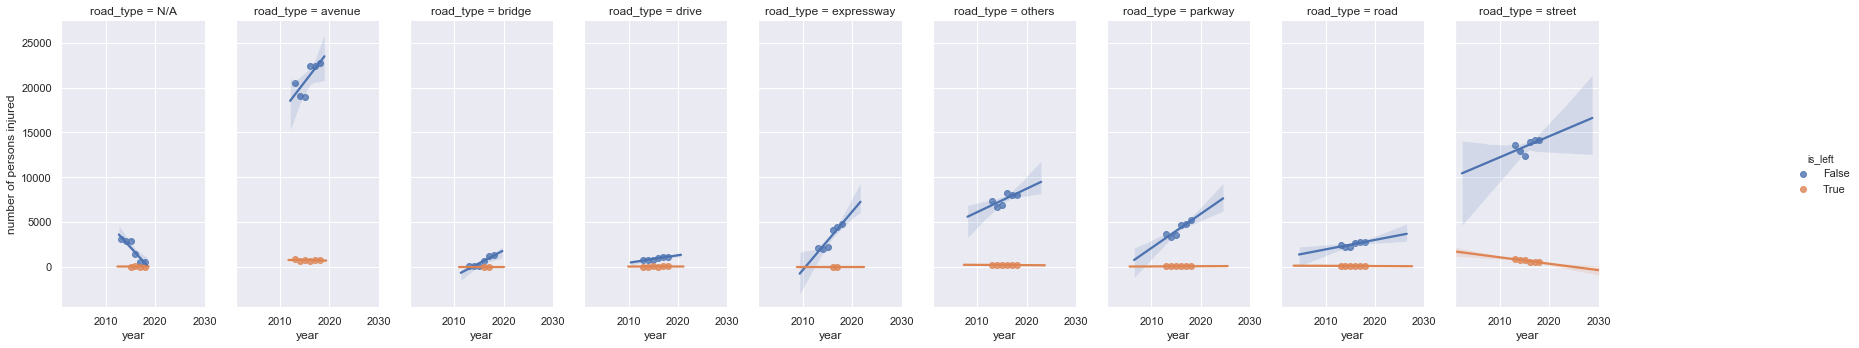

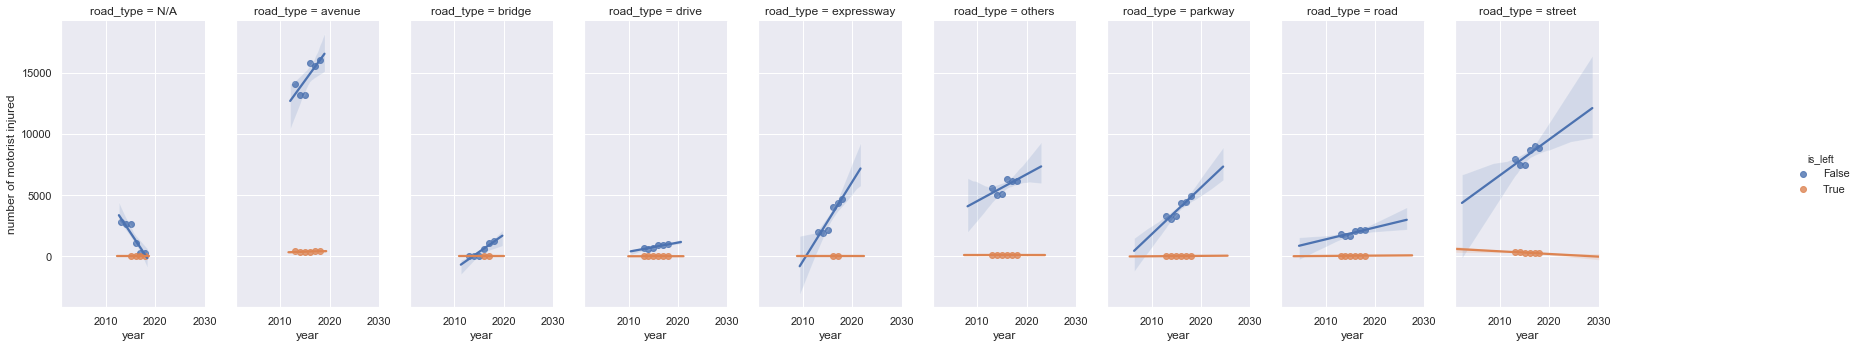

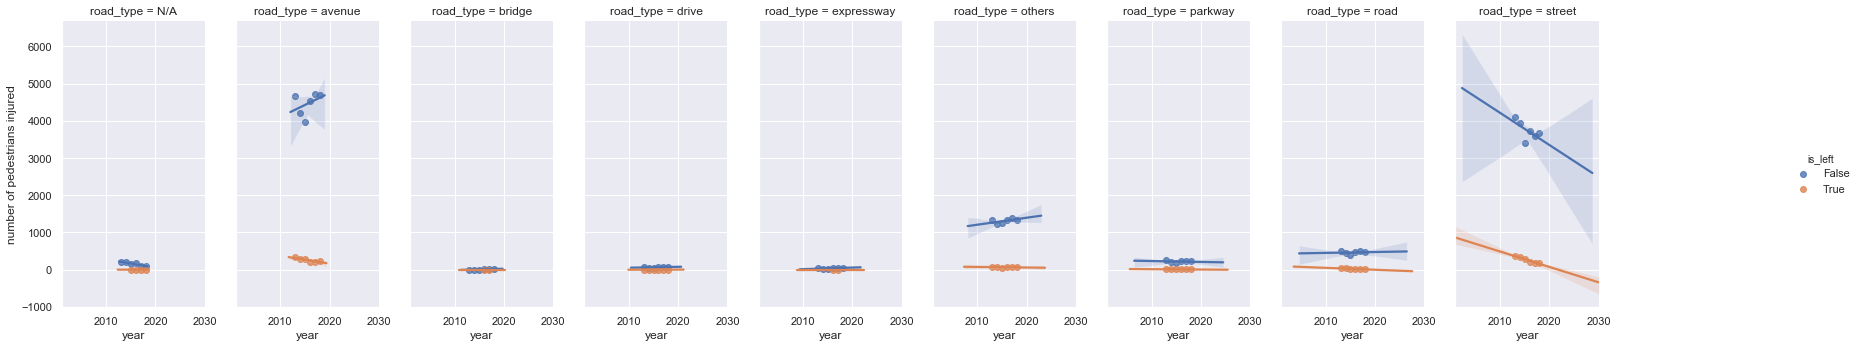

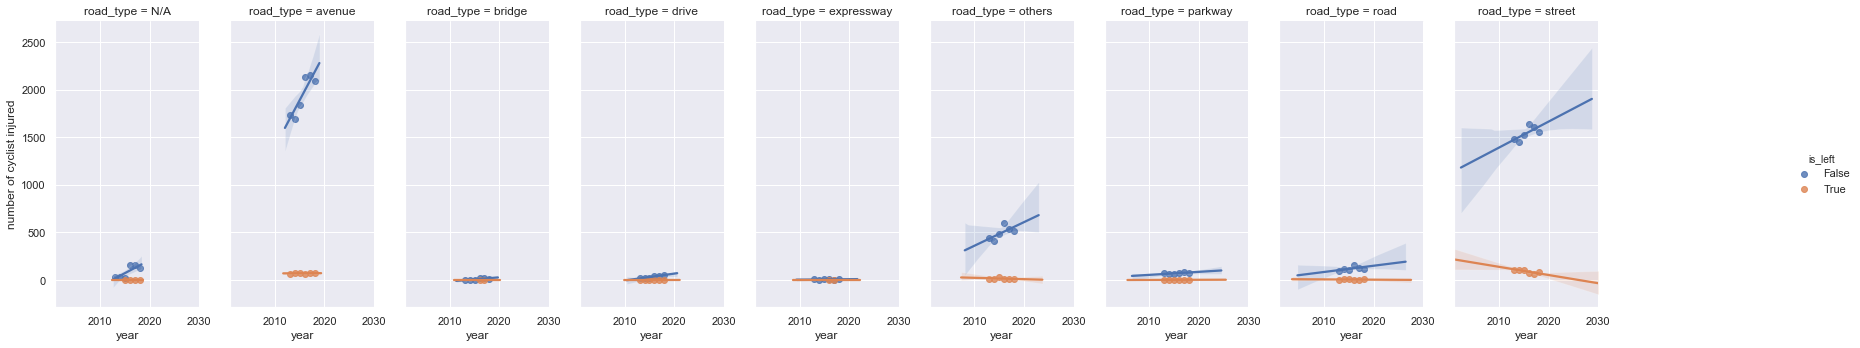

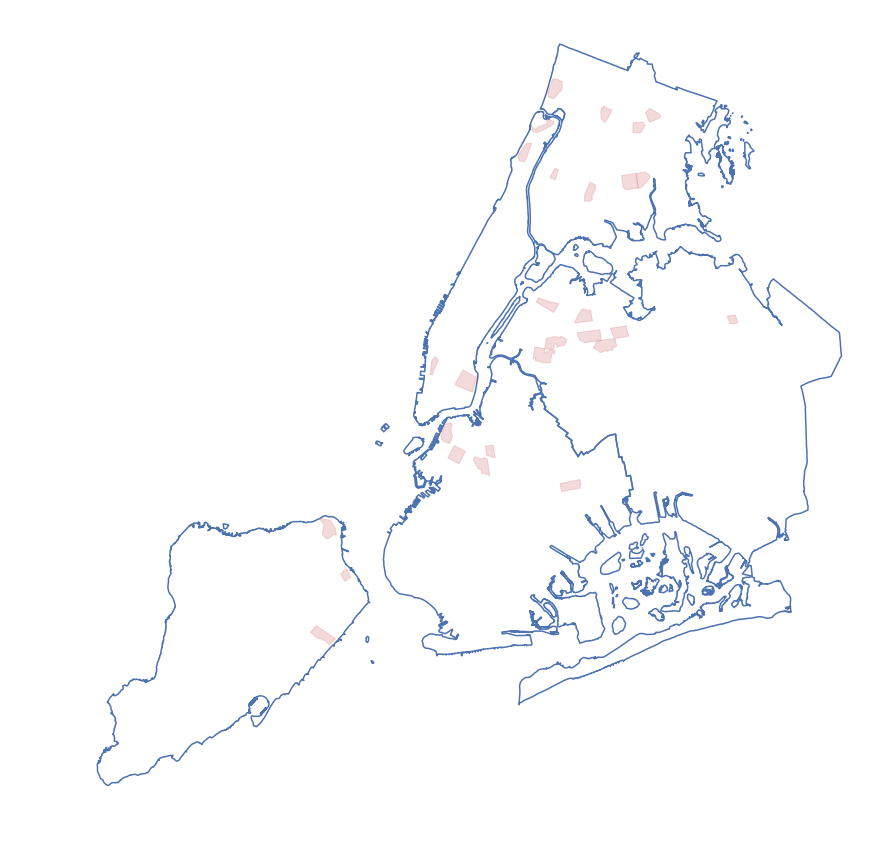

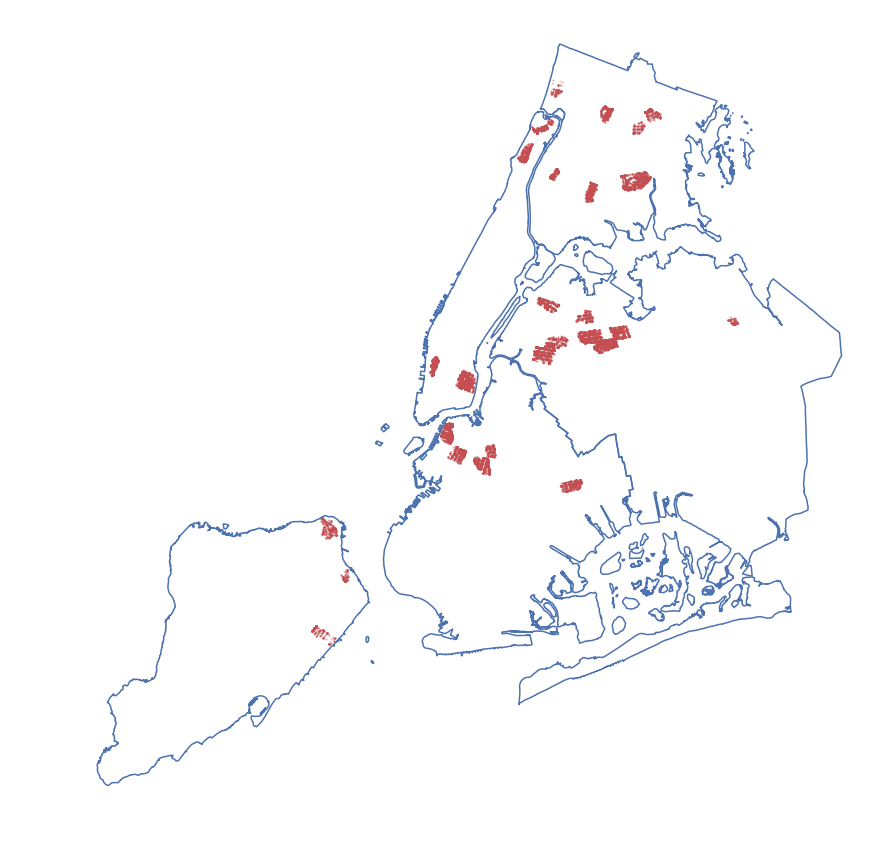

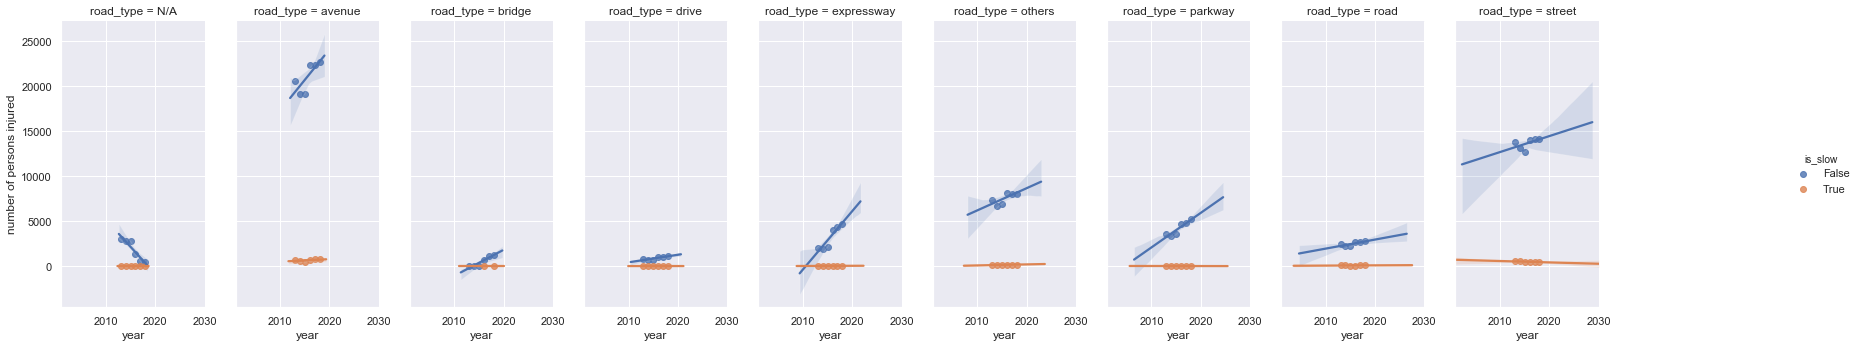

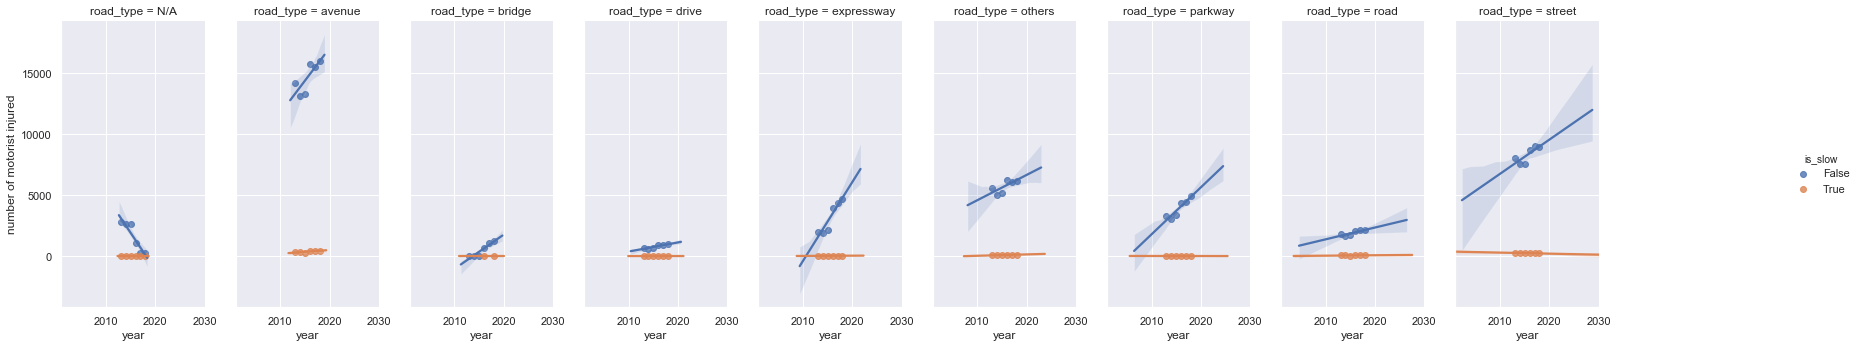

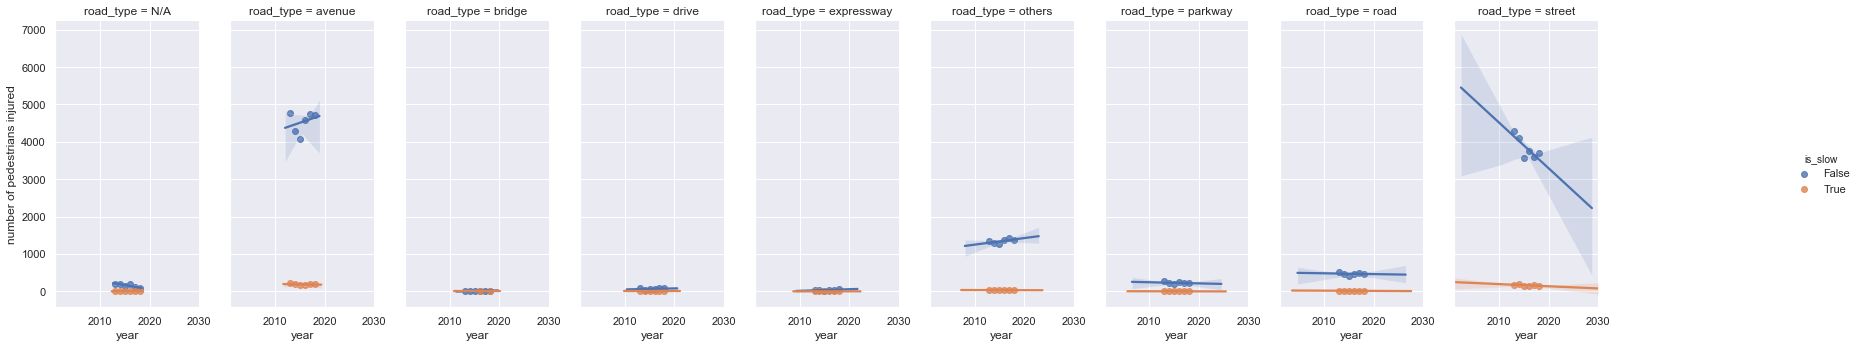

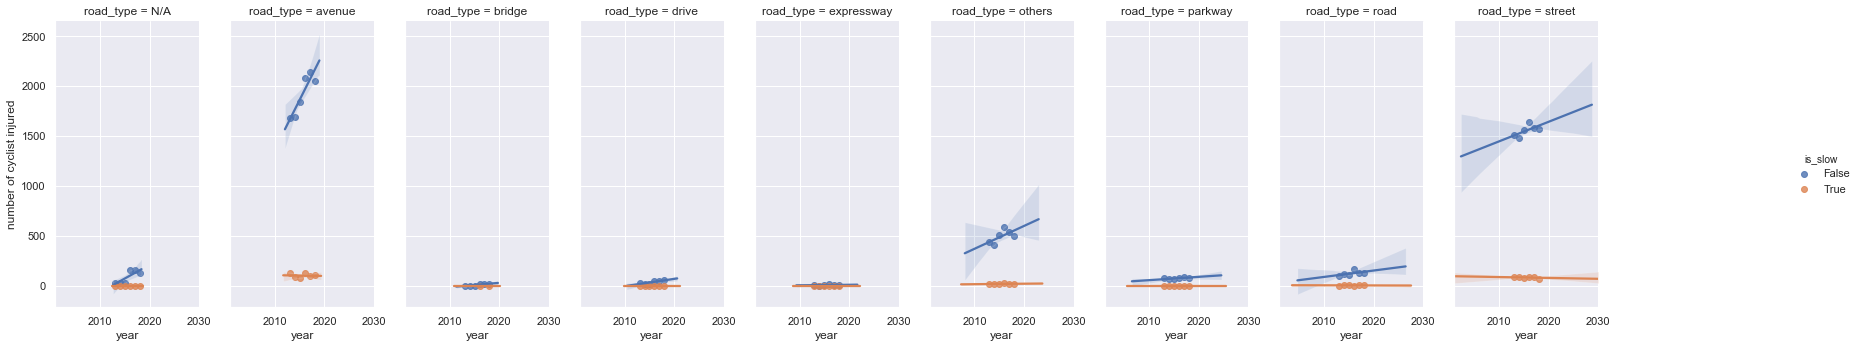

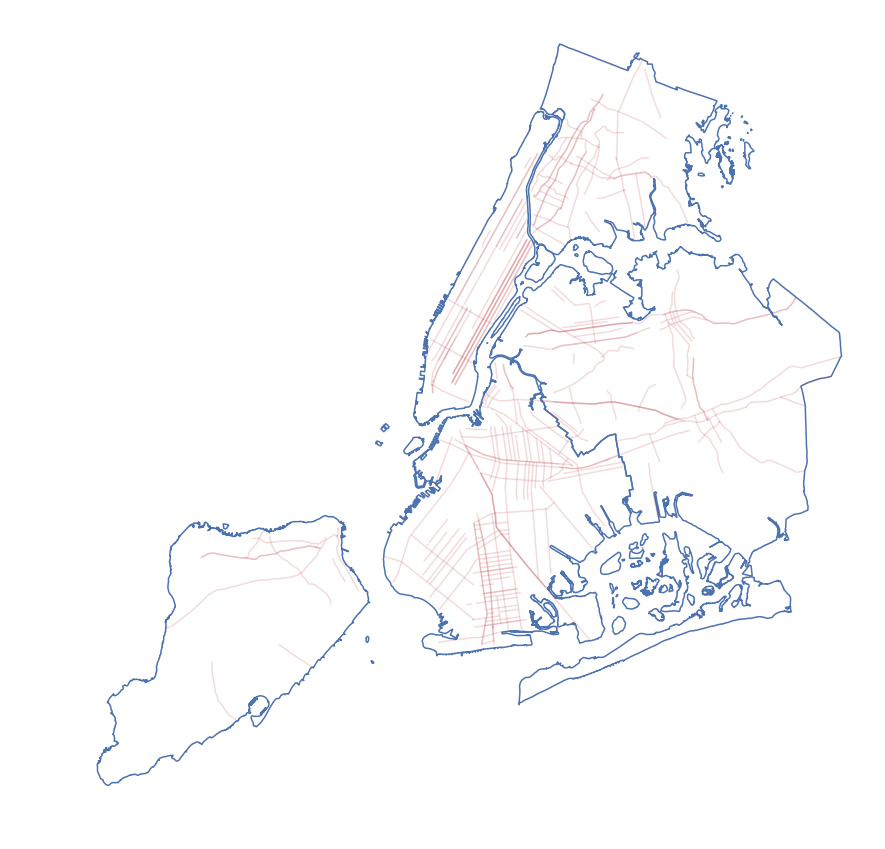

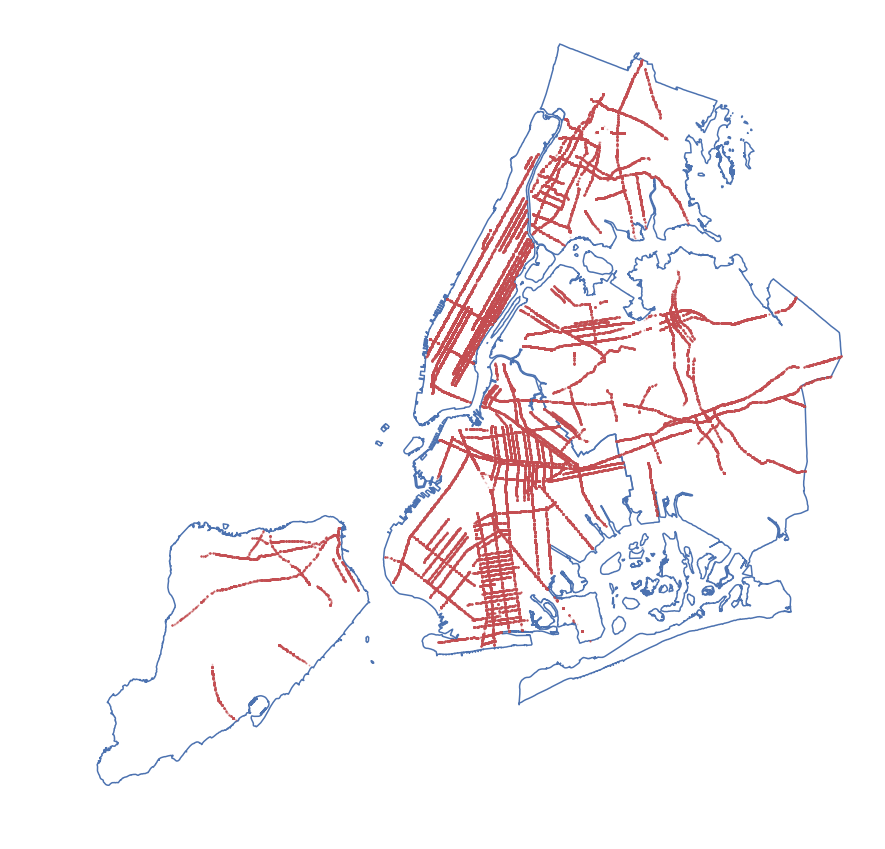

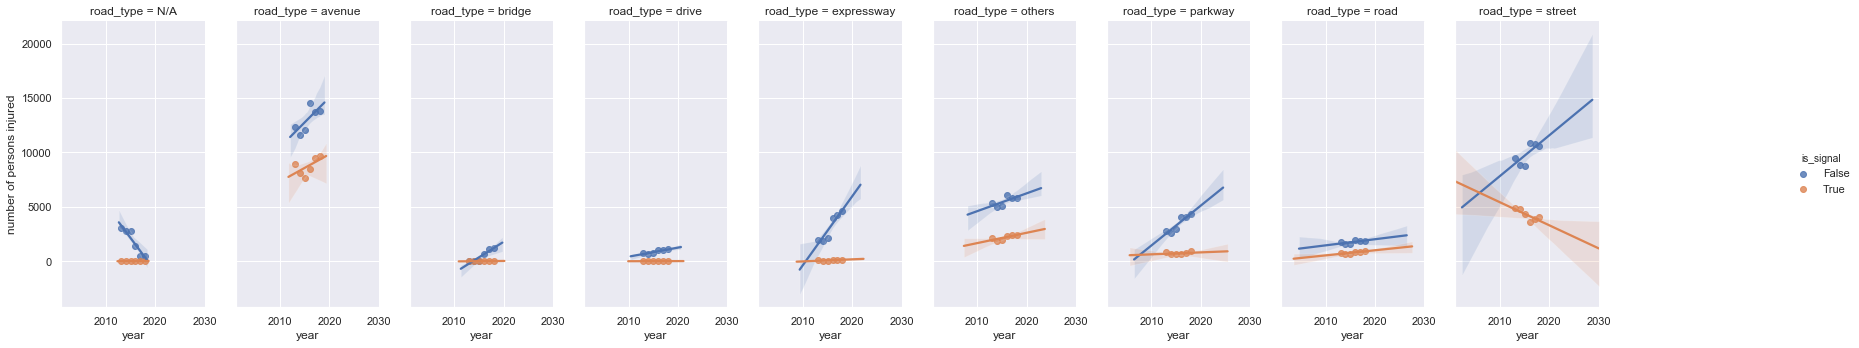

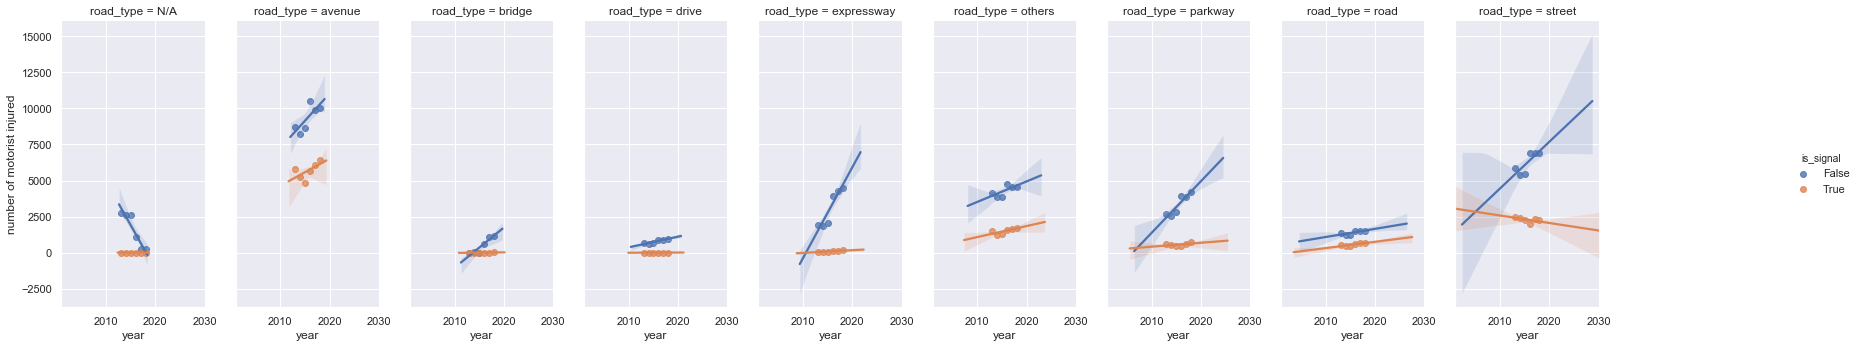

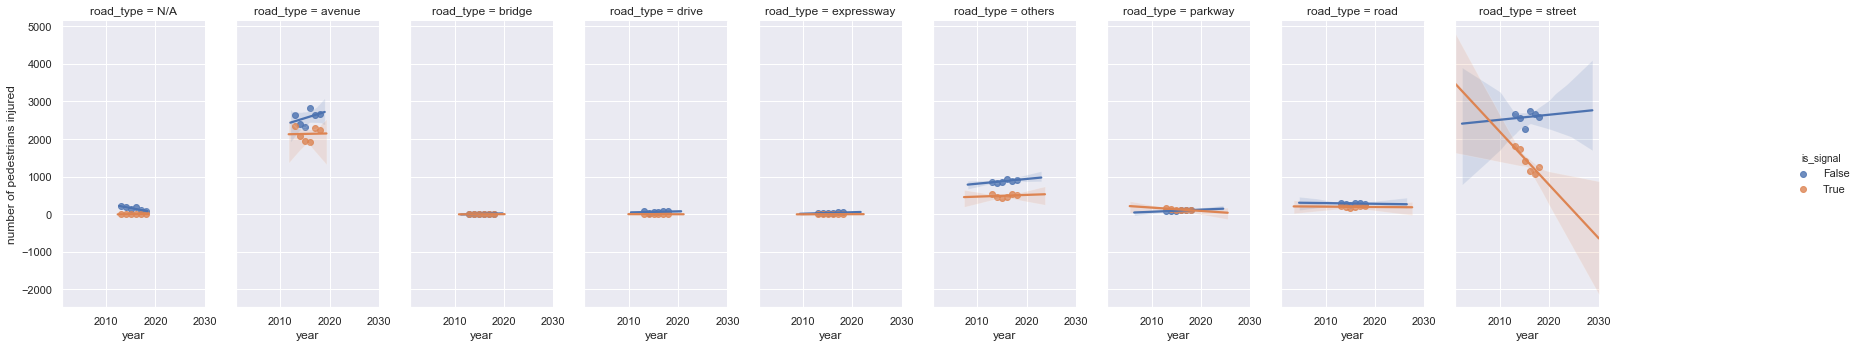

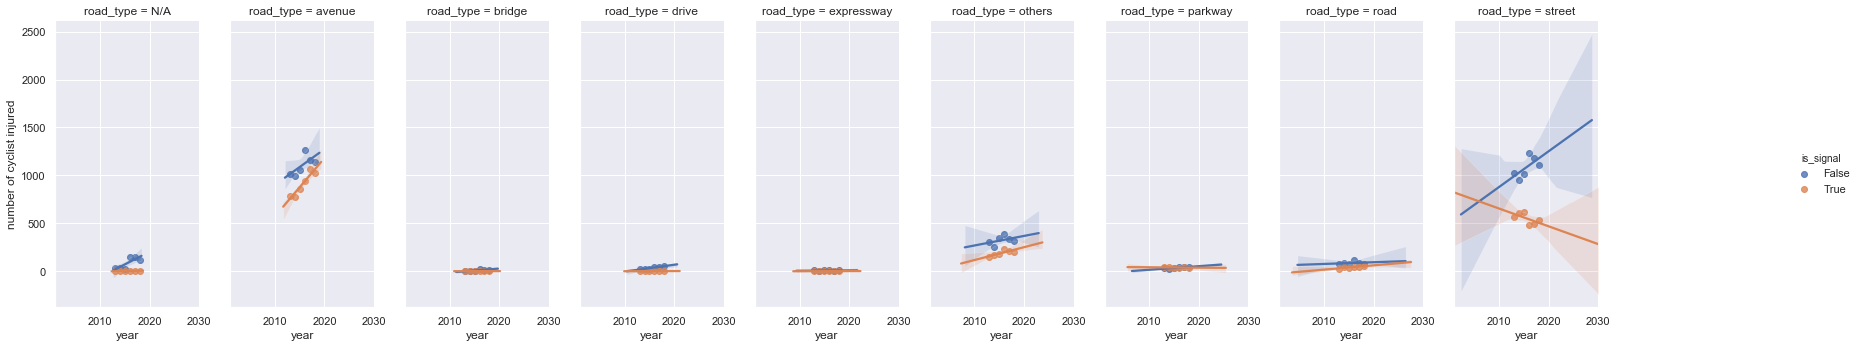

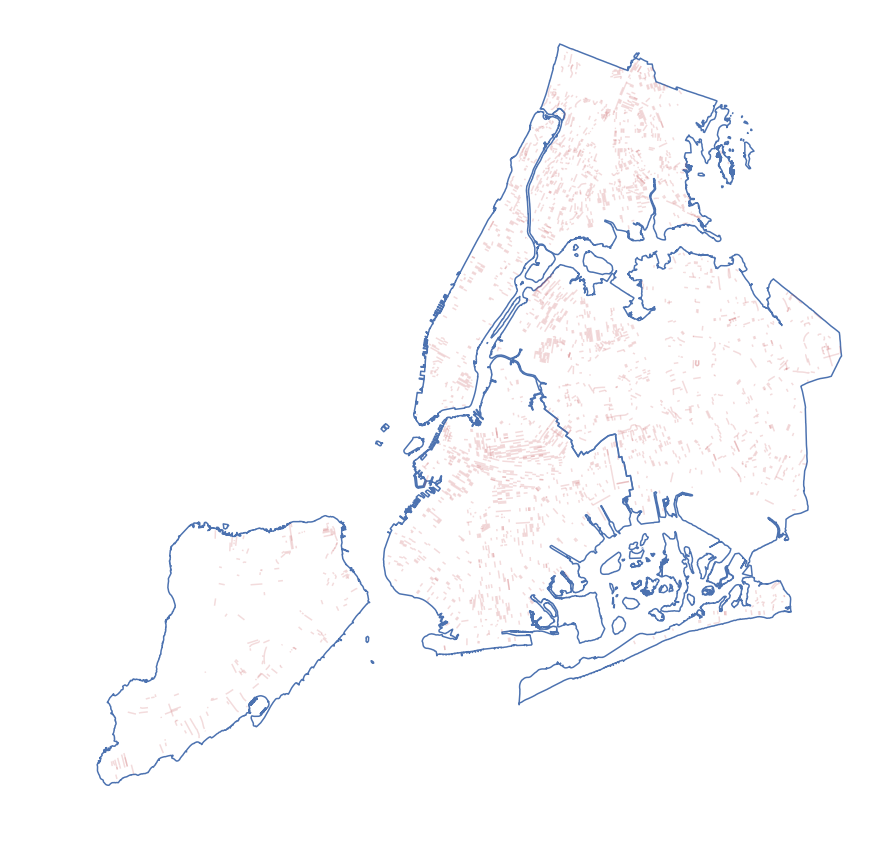

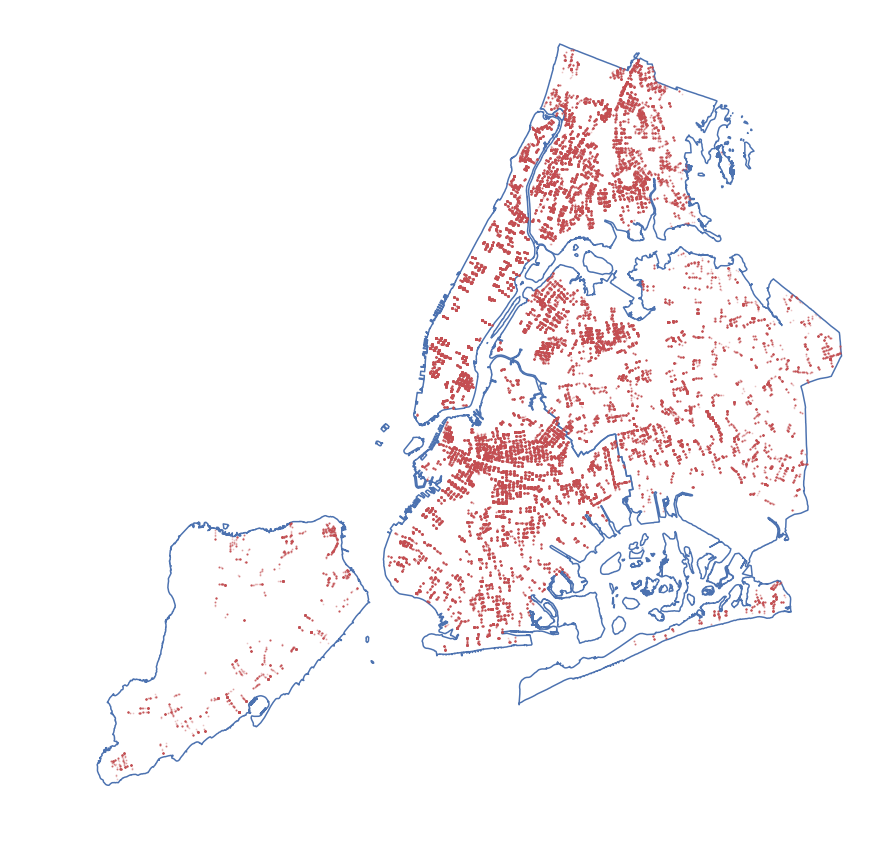

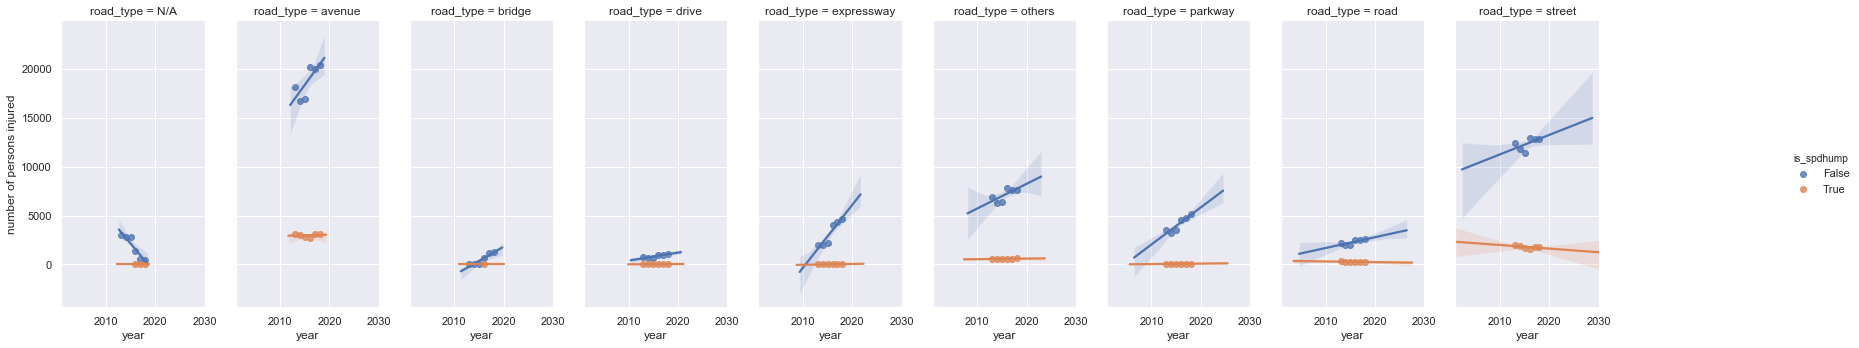

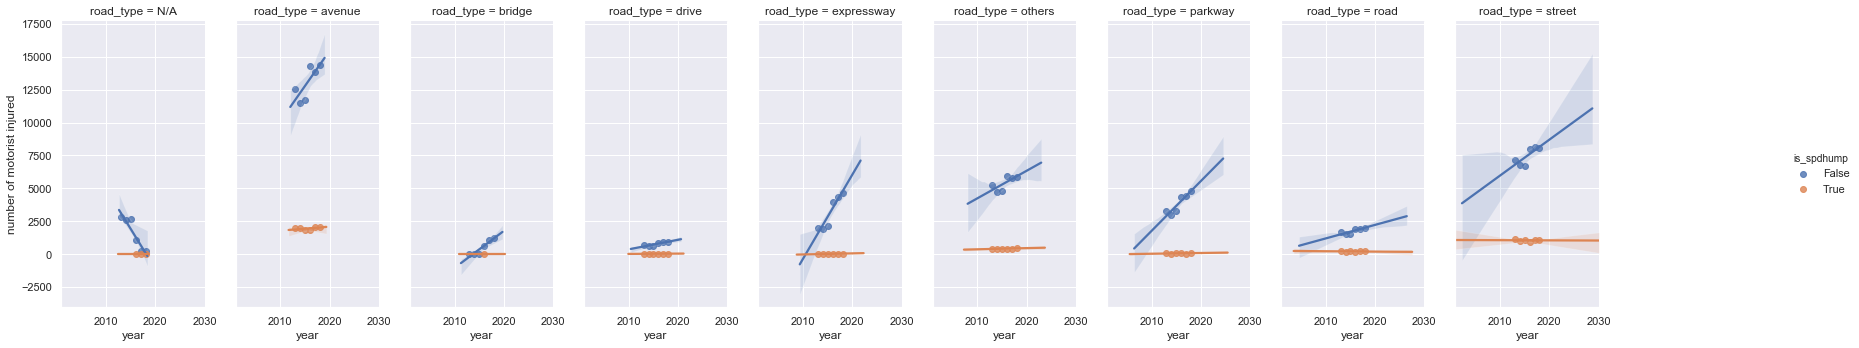

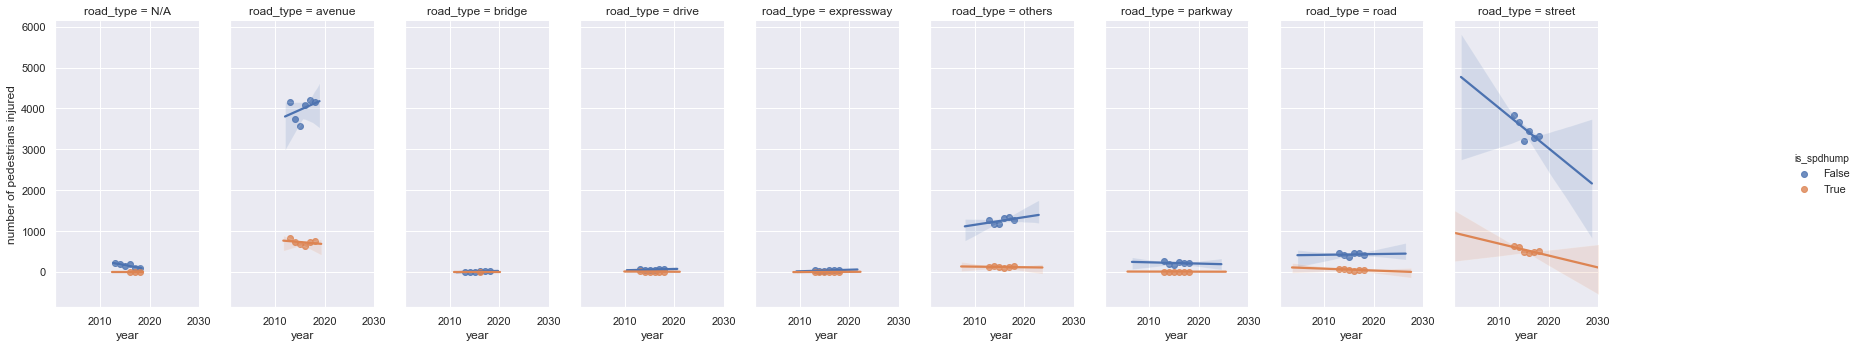

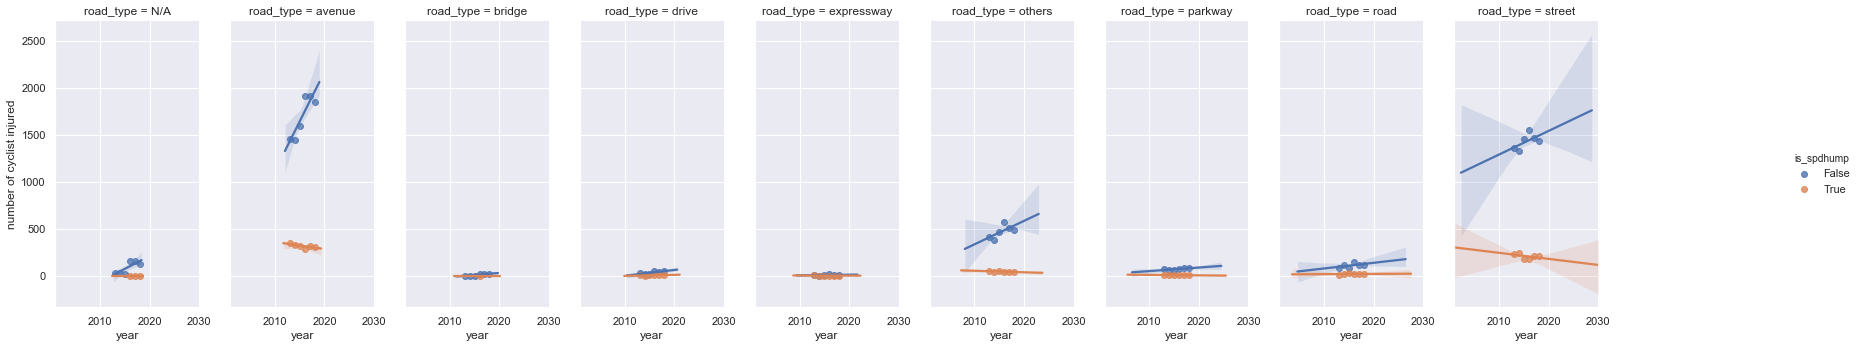

In [20]:
Plot_Geoms_On_NYCMap(df_arterial['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_arterial'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_arterial')

Plot_Geoms_On_NYCMap(df_bike['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_bike'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_bike')

Plot_Geoms_On_NYCMap(df_cross['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_cross'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_cross')

Plot_Geoms_On_NYCMap(df_left['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_left'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_left')

Plot_Geoms_On_NYCMap(df_slow['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_slow'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_slow')

Plot_Geoms_On_NYCMap(df_signal['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_signal'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_signal')

Plot_Geoms_On_NYCMap(df_spdhump['the_geom'], ON_MAP=False)
Plot_Geoms_On_NYCMap(df_col.loc[df_col['is_spdhump'],'location'].dropna(), ON_MAP=False)
Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_spdhump')

# Plot_Geoms_On_NYCMap(df_spdlimit['the_geom'], ON_MAP=False)
# Plot_Injuries_vs_Year(df_col, col='road_type', hue='is_spdlimit')

(263, 13)


ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

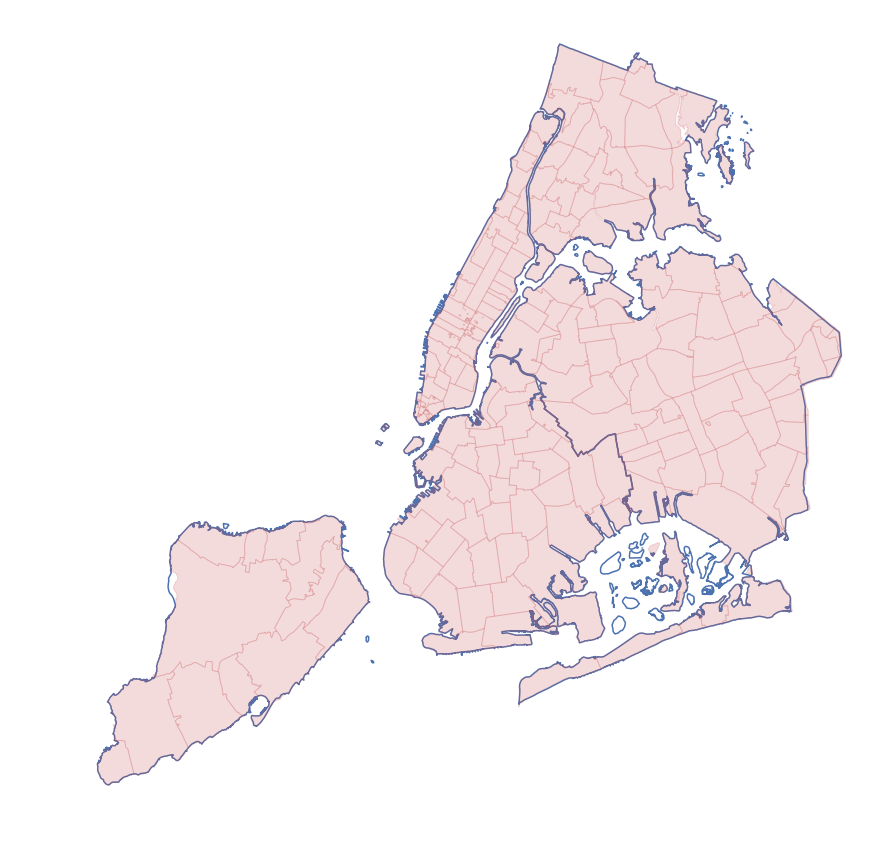

In [7]:
df_zip = gpd.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
# df_zip = gpd.read_file('2010 Census Tracts/geo_export_33be1ba3-3841-465b-a731-e3f37799a4ff.shp')

print(df_zip.shape)
Plot_Geoms_On_NYCMap(df_zip['geometry'], ON_MAP=False)
df_zip.head()

# http://www.jtrive.com/visualizing-population-density-by-zip-code-with-basemap.html

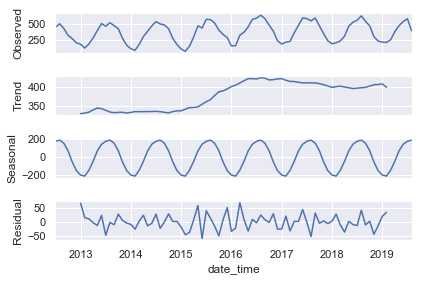

unique id       latitude     longitude  \
date_time                                             
2012-07-31  8006752543  589897.260113 -1.070929e+06   
2012-08-31  8436607385  591520.974855 -1.073912e+06   
2012-09-30  7787101995  574179.219526 -1.042394e+06   
2012-10-31  7968470292  581920.216678 -1.056455e+06   
2012-11-30  7575424083  548462.181483 -9.958321e+05   

            number of persons injured  number of persons killed  \
date_time                                                         
2012-07-31                     4855.0                      22.0   
2012-08-31                     4750.0                      27.0   
2012-09-30                     4689.0                      26.0   
2012-10-31                     4572.0                      21.0   
2012-11-30                     3995.0                      14.0   

            number of pedestrians injured  number of pedestrians killed  \
date_time                                                                 
2012-07-31                            855                             6   
2012-08-31                            850                            15   
2012-09-30                            893                            13   
2012-10-31                            977                            13   
2012-11-30                           1037                             8   

            number of cyclist injured  number of cyclist killed  \
date_time                                                         
2012-07-31                        450                         3   
2012-08-31                        507                         1   
2012-09-30                        434                         1   
2012-10-31                        329                         1   
2012-11-30                        277                         0   

            number of motorist injured  number of motorist killed      year  \
date_time                                                                     
2012-07-31                        3550                         13  34185892   
2012-08-31                        3393                         11  34487692   
2012-09-30                        3362                         12  33266408   
2012-10-31                        3260                          7  33928356   
2012-11-30                        2681                          6  31968668   

             month  dayofweek    hour  is_borough_null  is_location_null  \
date_time                                                                  
2012-07-31  118937      48651  231164           2508.0            2505.0   
2012-08-31  137128      51141  234510           2620.0            2615.0   
2012-09-30  148806      51576  219180           2436.0            2434.0   
2012-10-31  168630      47559  226610           2575.0            2573.0   
2012-11-30  174779      45226  213493           2420.0            2419.0   

            is_expressway  is_arterial  is_bike  is_cross  is_left  is_slow  \
date_time                                                                     
2012-07-31         1772.0       1996.0   2335.0      42.0    610.0    444.0   
2012-08-31         1710.0       1907.0   2321.0      38.0    563.0    443.0   
2012-09-30         1710.0       1935.0   2320.0      32.0    574.0    430.0   
2012-10-31         1709.0       1911.0   2320.0      34.0    620.0    420.0   
2012-11-30         1612.0       1812.0   2326.0      31.0    576.0    418.0   

            is_signal  is_spdhump  number of cyclist injured/killed  
date_time                                                            
2012-07-31     5340.0      1879.0                               453  
2012-08-31     5333.0      1833.0                               508  
2012-09-30     5389.0      1840.0                               435  
2012-10-31     5446.0      1842.0                               330  
2012-11-30     4970.0      1659.0                               277

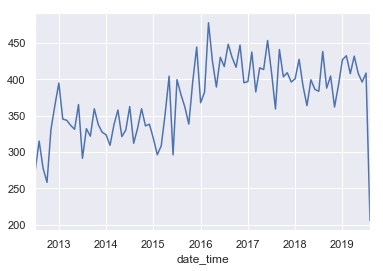

In [17]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

# cc = 'number of persons injured'
# cc = 'number of cyclist injured'
cc = 'number of cyclist injured/killed'

pp = df_col.set_index('date_time').resample('M').sum()

#ref) https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
result = seasonal_decompose(pp[cc], model='additive')
result.plot()
pyplot.show()

(result.observed - result.seasonal).plot()

pp.head()


In [111]:
# gg = df_col.groupby(['borough','year']).sum().reset_index()
# pp = gg[(2013 <= gg['year']) & (gg['year'] <= 2014)].copy()
# cc = 'number of persons injured'
# pp['percent'] = pp.groupby(['borough'])[cc].apply(lambda x: x.divide(x.reset_index(drop=True).loc[0]))
# pp.loc[pp['year']==2014, ['borough','year','number of persons injured','percent']]

(263, 14)


(917907.0504400574, 1074617.4766183202, 120436.01259019972, 279962.1368443966)

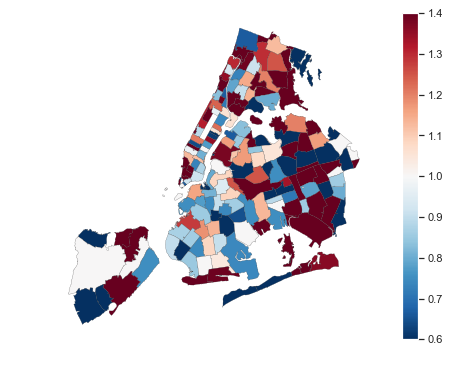

In [19]:
# cc = 'number of persons injured'
# cc = 'number of cyclist injured'
cc = 'number of cyclist injured/killed'
year = 2014
num_thresh = 0

# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
gg = df_col.groupby(['zip code','year'])[cc].sum().reset_index()
pp = gg[((year-1) <= gg['year']) & (gg['year'] <= year)].copy()
pp['percent'] = pp.groupby(['zip code'])[cc].apply(lambda x: x.divide(x.reset_index(drop=True).loc[0]))
ppp = pp.loc[(pp['year']==year) & (pp[cc]>=num_thresh), ['zip code','year',cc,'percent']].dropna()
ppp

df_zip2 = df_zip.join(ppp[['zip code','percent']].set_index('zip code'), on='ZIPCODE', how='left')
df_zip2.loc[df_zip2['percent'] >=1.4, 'percent'] = 1.4
df_zip2.loc[df_zip2['percent'] <=0.6, 'percent'] = 0.6
print(df_zip2.shape)
df_zip2.head()

fig, ax = plt.subplots(1, figsize=(10, 6))
# df_zip2.dropna().plot(ax=ax, column='percent', cmap='Blues', linewidth=0.8, edgecolor='0.8', legend=True)
df_zip2.dropna().plot(ax=ax, column='percent', cmap='RdBu_r', linewidth=0.2, edgecolor='0.2', legend=True)
ax.axis('off')
# ax.set_title(‘Preventable death rate in London’, fontdict={‘fontsize’: ‘25’, ‘fontweight’ : ‘3’})
# ax.annotate(‘Source: London Datastore, 2014’,xy=(0.1, .08),  xycoords=’figure fraction’, horizontalalignment=’left’, verticalalignment=’top’, fontsize=12, color=’#555555')

In [3]:
# DOB Permit Issuance (https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a)
if False:
    df_dob = pd.read_csv('DOB_Permit_Issuance.csv', dtype={'Zip Code':str})

    df_dob['Filing Date'] = pd.to_datetime(df_dob['Filing Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df_dob['Issuance Date'] = pd.to_datetime(df_dob['Issuance Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df_dob['Expiration Date'] = pd.to_datetime(df_dob['Expiration Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df_dob['Job Start Date'] = pd.to_datetime(df_dob['Job Start Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

    df_dob['location'] = df_dob[['LONGITUDE','LATITUDE']].apply(lambda x: Point(x[0],x[1]) if x.notnull().all() else np.nan, axis=1)

    pickle.dump(df_dob, open('DOB_Permit_Issuance.pickle', 'wb'))
else:
    df_dob = pickle.load(open('DOB_Permit_Issuance.pickle', 'rb'))        

print(df_dob.info())
df_dob.head()

C:\Users\bomsoo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1,8,9,10,15,25,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598485 entries, 0 to 3598484
Data columns (total 61 columns):
BOROUGH                             object
Bin #                               object
House #                             object
Street Name                         object
Job #                               int64
Job doc. #                          int64
Job Type                            object
Self_Cert                           object
Block                               object
Lot                                 object
Community Board                     object
Zip Code                            object
Bldg Type                           float64
Residential                         object
Special District 1                  object
Special District 2                  object
Work Type                           object
Permit Status                       object
Filing Status                       object
Permit Type                         object
Permit Sequence #           

BOROUGH    Bin # House #       Street Name      Job #  Job doc. #  \
0      BRONX  2016878    2844        BRIGGS AVE  220391154           1   
1      BRONX  2129332     276          E 169 ST  220687861           1   
2  MANHATTAN  1028634      37    WEST 72 STREET  123019401           1   
3      BRONX  2129332     276          E 169 ST  220687861           1   
4  MANHATTAN  1017822     145  EAST 16TH STREET  123749729           1   

  Job Type Self_Cert Block Lot Community Board Zip Code  Bldg Type  \
0       A3         Y  3295  43             207    10458        2.0   
1       NB         Y  2439  46             204    10456        2.0   
2       A2         Y  1125   9             107    10023        2.0   
3       NB         Y  2439  46             204    10456        2.0   
4       A2         Y   872  35             106    10003        2.0   

  Residential Special District 1 Special District 2 Work Type Permit Status  \
0         YES                NaN                NaN        EQ        ISSUED   
1         NaN                NaN                NaN       NaN     RE-ISSUED   
2         YES                NaN                NaN        OT        ISSUED   
3         NaN                NaN                NaN       NaN        ISSUED   
4         YES                NaN                NaN        OT        ISSUED   

  Filing Status Permit Type  Permit Sequence # Permit Subtype Oil Gas  \
0       RENEWAL          EQ                  6             SH     NaN   
1       RENEWAL          FO                  2             EA     NaN   
2       RENEWAL          EW                  3             OT     NaN   
3       RENEWAL          FO                  2            NaN     NaN   
4       INITIAL          EW                  1             OT     NaN   

             Site Fill Filing Date Issuance Date Expiration Date  \
0                  NaN  2019-06-13    2019-10-17      2020-10-16   
1  USE UNDER 300 CU.YD  2019-10-17    2019-10-17      2020-04-01   
2       NOT APPLICABLE  2019-05-01    2019-10-17      2020-05-20   
3  USE UNDER 300 CU.YD  2019-10-17    2019-10-17      2020-04-01   
4       NOT APPLICABLE  2019-06-13    2019-10-17      2020-07-03   

  Job Start Date Permittee's First Name Permittee's Last Name  \
0     2014-06-24              SIMRANPAL                 SINGH   
1     2019-10-17                 ALBERT                BABAEV   
2     2017-06-19                MICHAEL                 PAQUE   
3     2019-09-27                 ALBERT                BABAEV   
4     2019-10-17                 GEORGE           TSIMOYIANIS   

  Permittee's Business Name Permittee's Phone # Permittee's License Type  \
0        ROCK GROUP NY CORP          7184508262                       GC   
1    NORTHBAY BUILDERS CORP          7186319001                       GC   
2    PAQUE CONSTRUCTION INC          9174746574                       GC   
3    NORTHBAY BUILDERS CORP          7186319001                       GC   
4  ALL CITY REMODELING, INC          7184330623                       GC   

  Permittee's License # Act as Superintendent Permittee's Other Title  \
0                610440                   NaN                     NaN   
1                614426                   NaN                     NaN   
2                620125                   NaN                     NaN   
3                614426                   NaN                     NaN   
4                 33913                   NaN                     NaN   

  HIC License Site Safety Mgr's First Name Site Safety Mgr's Last Name  \
0         NaN                          NaN                         NaN   
1         NaN                          NaN                         NaN   
2         NaN                        MALIK                    HARRISON   
3         NaN                          NaN                         NaN   
4         NaN                          NaN                         NaN   

  Site Safety Mgr Business Name Superintendent First & Last Name  \
0               

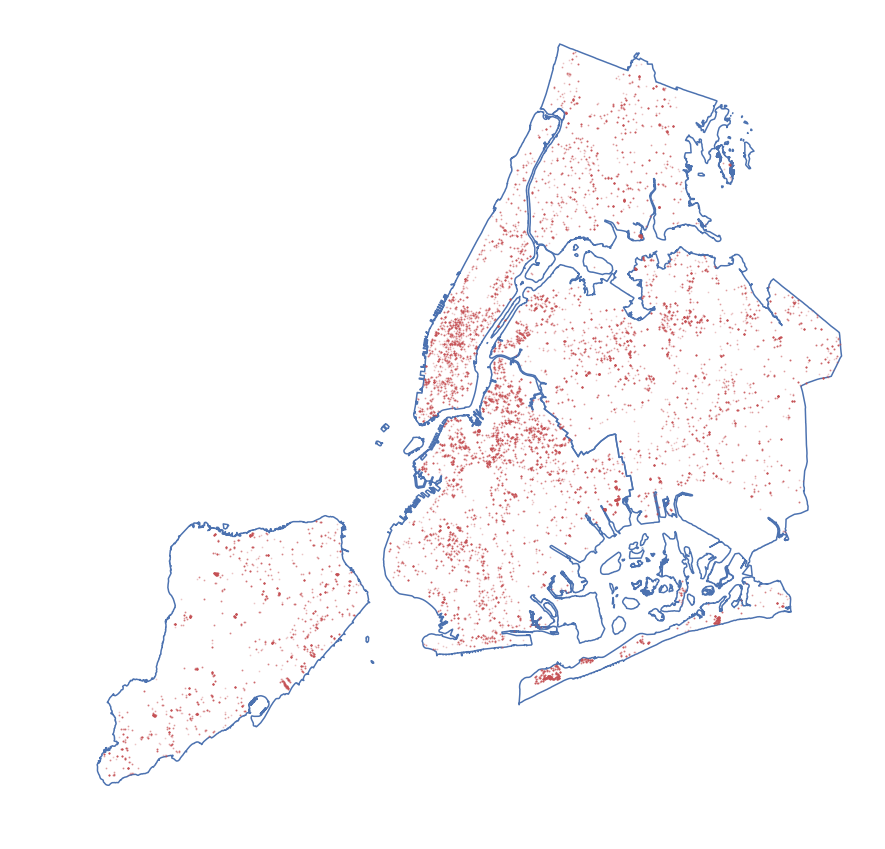

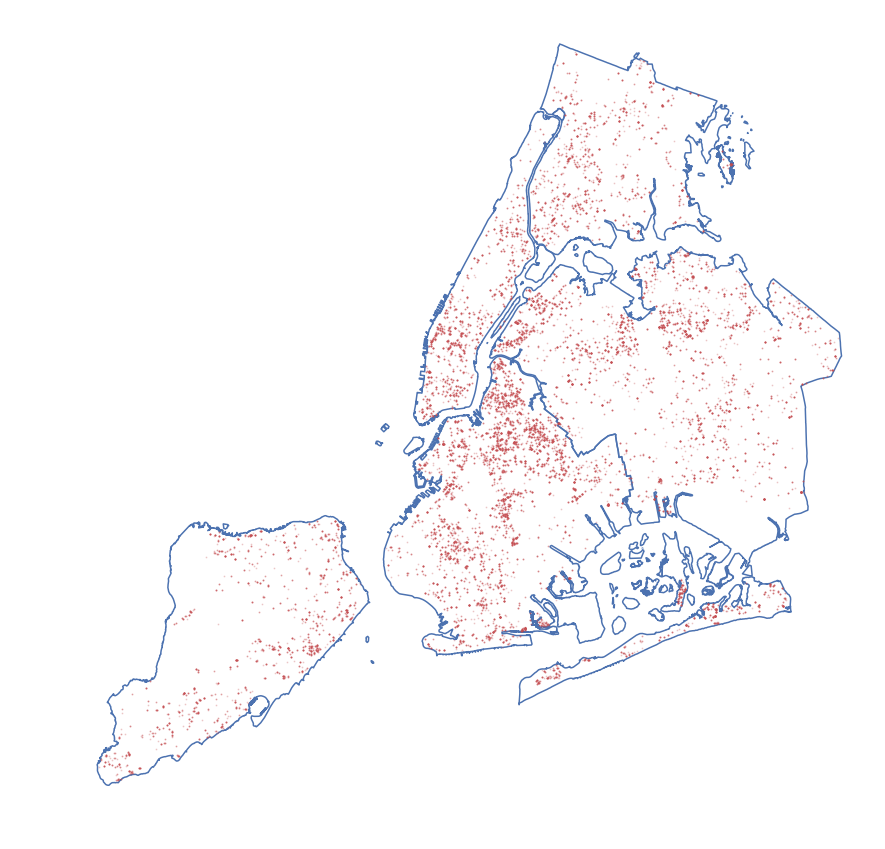

In [12]:
ii = ((df_dob['Issuance Date'].dt.year==2014) & 
      (df_dob['Job Type'].apply(lambda x: x in ['NB','DM','SG'])))
Plot_Geoms_On_NYCMap(df_dob.loc[ii, 'location'].dropna(), ON_MAP=False)

ii = ((df_dob['Issuance Date'].dt.year==2018) & 
      (df_dob['Job Type'].apply(lambda x: x in ['NB','DM','SG'])))
Plot_Geoms_On_NYCMap(df_dob.loc[ii, 'location'].dropna(), ON_MAP=False)

is_spdhump  year  number of cyclist injured/killed  pct_change
0      <Total>  2012                              2215         NaN
1      <Total>  2013                              4086    0.844695
2      <Total>  2014                              4020   -0.016153
3      <Total>  2015                              4296    0.068657
4      <Total>  2016                              5025    0.169693
5      <Total>  2017                              4916   -0.021692
6      <Total>  2018                              4735   -0.036819
7      <Total>  2019                              3094   -0.346568
8   Speed Hump  2012                               385         NaN
9   Speed Hump  2013                               648    0.683117
10  Speed Hump  2014                               628   -0.030864
11  Speed Hump  2015                               579   -0.078025
12  Speed Hump  2016                               523   -0.096718
13  Speed Hump  2017                               598    0.143403
14  Speed Hump  2018                               580   -0.030100
15  Speed Hump  2019                               398   -0.313793

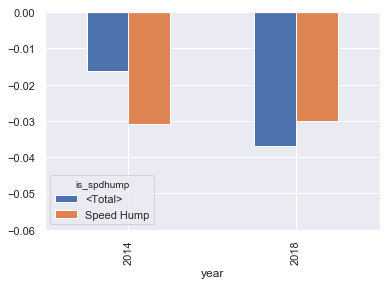

In [125]:
# policy = 'is_bike'; policy_name='Bike Zone'
policy = 'is_spdhump'; policy_name='Speed Hump'
cc = 'number of cyclist injured/killed'

gg = df_col.groupby([policy,'year'])[cc].sum().reset_index()

tt = pd.concat([gg.groupby('year')[cc].sum().reset_index(), gg[[policy,'year',cc]]], axis=0, sort=False)
tt = tt[tt[policy] != False]
tt.loc[tt[policy].notnull(), policy] = policy_name
tt.loc[tt[policy].isnull(), policy] = '<Total>'

tt['pct_change'] = tt.groupby(policy)[cc].pct_change()

ss = tt.loc[tt['year'].apply(lambda x: x in [2014,2018])]
ss.set_index(['year',policy])['pct_change'].unstack().plot(kind='bar', ylim=(-0.06,0))

tt[[policy,'year',cc,'pct_change']]